#0.Постановка задачи

**Описание эксперимента**<br>
Отдел маркетинга предложил новый способ воздействия на клиентские покупки — пуш-уведомления в приложении. До этого основным маркетинговым воздействием было уведомление о новых товарах и скидках с помощью баннера в приложении. Отдел маркетинга предполагает, что новый вид уведомлений более эффективен и с точки зрения конверсии в покупку, и с точки зрения среднего чека.

Чтобы ответить на вопрос, какой способ лучше, с помощью данных, было проведено A/B-тестирование во всех городах России, в которых присутствует ретейлер. Контрольной группе по-прежнему присылали уведомления об акциях и скидках в форме баннера, а тестовой — в форме пуш-уведомления.

Эксперимент продолжался 3 месяца.

Сплит-система: клиенты разбиты на две группы одинакового размера случайным образом.

Были исследованы две таргет-метрики: конверсия из рекламы в покупку и средний чек покупки.

**Задача**<br>
Очистить данные и подготовить их к дальнейшему анализу.<br>
Проанализировать результаты A/B-тестов и подготовить визуализации.<br>
Провести сегментацию по городам и торговым точкам и рассчитать результаты A/B-теста на каждом сегменте.<br>
Сделать выводы и оформить результаты исследования в форме удобного Excel-калькулятора.<br>

#1 Импорт модулей для работы

In [ ]:
#модули для статистической обработки
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms

#модули графической визуализации
import matplotlib.pyplot as plt
import seaborn as sns

#модуль, помогающий отследить процес выполнения
#используется в разделе 2.3 для отслеживания итерации бутстрепа
from tqdm.auto import tqdm

#подчистка выводимых данных от отладочной информации
import warnings
warnings.filterwarnings("ignore")

#2 Разведочный анализ данных (EDA)

##2.1 Импорт данных

Данные о заказах

In [ ]:
skylenta_orders = pd.read_excel('/content/drive/MyDrive/Диплом. SkyPro/Новый диплом датасет.xlsx', parse_dates= ['dtime_pay'], sheet_name='Данные')
skylenta_orders.head(3)

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221000
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992000
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744000


Данные о клиентах

In [ ]:
skylenta_clients = pd.read_excel('/content/drive/MyDrive/Диплом. SkyPro/Новый диплом датасет.xlsx', parse_dates= ['dtime_ad'], sheet_name='Clients')
skylenta_clients.head(3)

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414000,0,212
1,193942,NaN,0,13
2,226069,2022-07-11 16:28:38.511000,1,54


Данный о торговых точках

In [ ]:
skylenta_regions = pd.read_excel('/content/drive/MyDrive/Диплом. SkyPro/Новый диплом датасет.xlsx', sheet_name='Region_dict')
skylenta_regions.head(3)

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов


Объединение данных

In [ ]:
skylenta_data00 = (skylenta_clients
 .merge(skylenta_orders, left_on = 'id_client', right_on='id_client', how = 'left')
 .merge(skylenta_regions, left_on = 'id_trading_point', right_on='id_trading_point', how = 'left'))
skylenta_data00

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city
0,180844,2022-06-08 18:38:41.414000,0,212,157381.0,5349.0,2022-10-12 00:47:53.057000,Красноярск
1,193942,NaN,0,13,248710.0,4144.0,NaN,Нижний Новгород
2,226069,2022-07-11 16:28:38.511000,1,54,NaN,NaN,NaN,Мурманск
3,183981,2022-06-16 12:23:59.289000,1,991,136901.0,2592.0,2022-10-06 20:20:51.307000,Казань
4,183981,2022-06-16 12:23:59.289000,1,991,168411.0,3730.0,2022-07-18 13:09:51.622000,Казань
...,...,...,...,...,...,...,...,...
63289,189084,2022-06-29 04:34:42.610000,1,439,192923.0,2986.0,2022-07-01 11:57:29.563000,Казань
63290,182758,2022-06-13 11:28:37.856000,1,573,247275.0,6369.0,2022-07-14 03:42:28.949000,Санкт-Петербург
63291,182758,2022-06-13 11:28:37.856000,1,573,250369.0,3339.0,2022-07-05 20:53:00.231000,Санкт-Петербург
63292,182758,2022-06-13 11:28:37.856000,1,573,250838.0,4012.0,2022-08-22 18:56:40.806000,Санкт-Петербург


##2.2 Очистка данных от пропусков

Определение количества и распределения пропущенных значений

In [ ]:
pd.DataFrame({'Число пропусков данных': skylenta_data00.isna().sum(),
              'Доля пропусков данных': skylenta_data00.isna().sum()/skylenta_data00.shape[0]})

,Число пропусков данных,Доля пропусков данных
id_client,0,0.000000
dtime_ad,308,0.004866
nflag_test,0,0.000000
id_trading_point,0,0.000000
id_order,25893,0.409091
amt_payment,27449,0.433675
dtime_pay,27734,0.438177
city,0,0.000000


Предварительно оценим, как распределены пропущенные значения

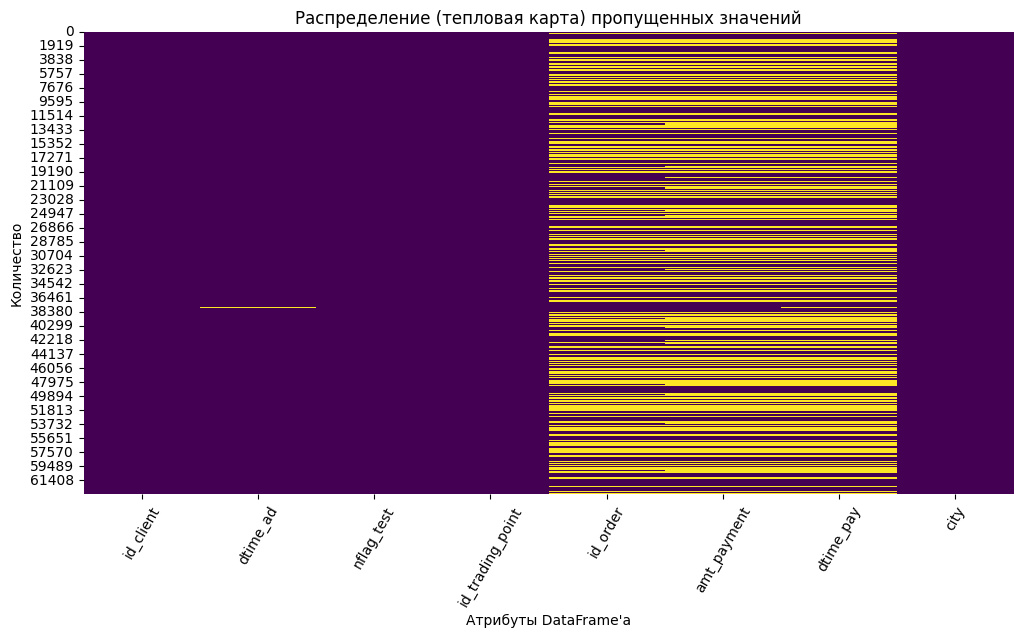

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(skylenta_data00.isnull(), cbar= False, cmap='viridis')
plt.title('Распределение (тепловая карта) пропущенных значений')
plt.xlabel("Атрибуты DataFrame'а")
plt.ylabel("Количество")
plt.xticks(rotation=60)
plt.show()

В строках, в которых поле **dtime_ad** не равно **Null**, встречаются **Null** значения в полях **amt_payment** и **dtime_pay**. Такие записи не являются пропусками в данных, а свидетельствуют об отсутствии в данном случае конверсии показа рекламы в платеж.

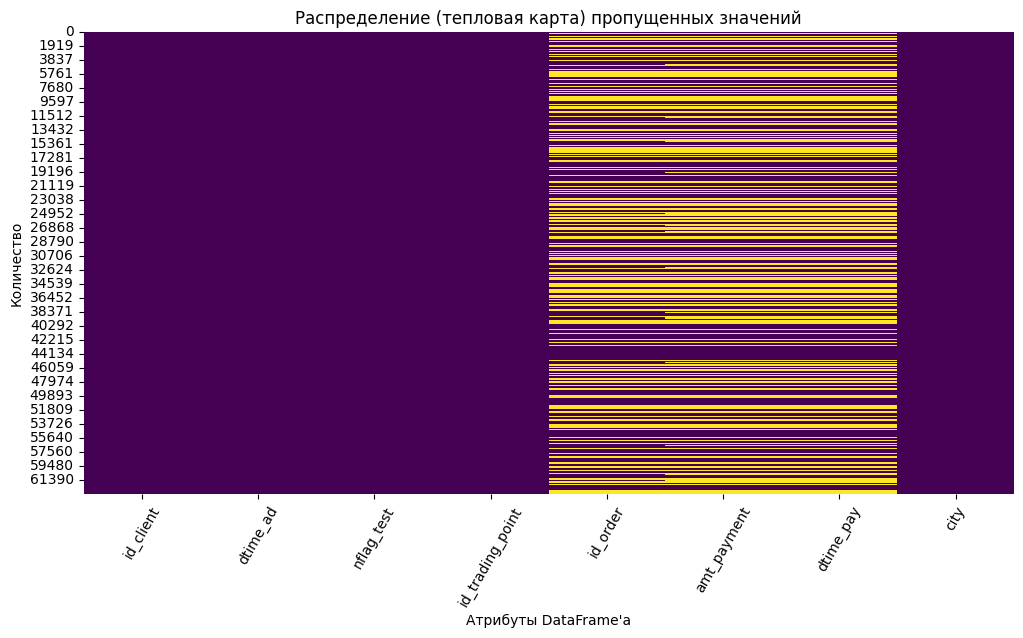

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(skylenta_data00[skylenta_data00['dtime_ad'].isnull() == False].isnull(), cbar= False, cmap='viridis')
plt.title('Распределение (тепловая карта) пропущенных значений')
plt.xlabel("Атрибуты DataFrame'а")
plt.ylabel("Количество")
plt.xticks(rotation=60)
plt.show()

В то же время, записи, для которых не заполнены поля **id_client** и **dtime_ad** считаем ошибками статистики<br>
Пропуски в поле **id_client** присутствуют в строках, где отсутствуют значения и в остальных полях <br>
Пропуски в поле **dtime_ad** свидетельствуют об ошибках в сборе статистики о показе рекламы. В таких записях мы не можем быть уверены, что реклама была показана. Чтобы указанные данные не искажали статистику - удалим подобные записи

In [ ]:
skylenta_data01 = skylenta_data00.copy()
skylenta_data01.dropna(how = 'any', subset=['id_client','dtime_ad'], inplace = True)

In [ ]:
pd.DataFrame({'Число пропусков данных': skylenta_data01.isna().sum(),
              'Доля пропусков данных': skylenta_data01.isna().sum()/skylenta_data01.shape[0]})

,Число пропусков данных,Доля пропусков данных
id_client,0,0.000000
dtime_ad,0,0.000000
nflag_test,0,0.000000
id_trading_point,0,0.000000
id_order,25893,0.411091
amt_payment,27409,0.435160
dtime_pay,27426,0.435430
city,0,0.000000


Предположение о том, что **NULL** значения в полях **amt_payment** и **dtime_pay** это только несовершенные покупки не всегда подтверждается.<br> Есть записи, где одно поле заполнено без другого, что указывает на ошибки в данных. Выведем такие записи

In [ ]:
skylenta_data01[
    (skylenta_data01['amt_payment'].isnull() == False) & (skylenta_data01['dtime_pay'].isnull() == True) |
    (skylenta_data01['amt_payment'].isnull() == True) & (skylenta_data01['dtime_pay'].isnull() == False)
     ]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city
3531,182290,2022-06-12 07:21:38.424000,1,1654,146598.0,4450.0,NaN,Москва
5467,207014,2022-08-13 01:50:17.366000,1,1654,277390.0,3642.0,NaN,Москва
8010,183063,2022-06-14 05:46:55.568000,1,1654,100594.0,3338.0,NaN,Москва
8747,203062,2022-08-03 04:51:43.618000,1,2212,187726.0,5937.0,NaN,Москва
12285,203762,2022-08-04 22:45:43.904000,1,1654,155276.0,3615.0,NaN,Москва
16492,205269,2022-08-08 16:13:18.125000,1,2652,188686.0,5166.0,NaN,Москва
37003,186635,2022-06-23 01:48:59.938000,1,6543,262087.0,5637.0,NaN,Москва
44533,193554,2022-07-10 08:19:46.897000,1,1287,279265.0,5525.0,NaN,Москва
48603,206836,2022-08-12 15:33:58.322000,1,6543,171949.0,3000.0,NaN,Москва
48752,206920,2022-08-12 20:48:30.848000,1,1002,172913.0,3188.0,NaN,Москва


Уберем данные записи из данных


In [ ]:
delete_rows = skylenta_data01[
    (skylenta_data01['amt_payment'].isnull() == False) & (skylenta_data01['dtime_pay'].isnull() == True) |
    (skylenta_data01['amt_payment'].isnull() == True) & (skylenta_data01['dtime_pay'].isnull() == False)
     ].index
skylenta_data01 = skylenta_data01[skylenta_data01.index.isin(delete_rows) == False].reset_index(drop = True)

In [ ]:
pd.DataFrame({'Число пропусков данных': skylenta_data01.isna().sum(),
              'Доля пропусков данных': skylenta_data01.isna().sum()/skylenta_data01.shape[0]})

,Число пропусков данных,Доля пропусков данных
id_client,0,0.000000
dtime_ad,0,0.000000
nflag_test,0,0.000000
id_trading_point,0,0.000000
id_order,25893,0.411202
amt_payment,27409,0.435278
dtime_pay,27409,0.435278
city,0,0.000000


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

В сете остались записи, где поле **id_order**, **amt_payment** и **dtime_pay** равны NULL:<br>

In [ ]:
skylenta_data01[(skylenta_data01['id_order'].isnull()) & (skylenta_data01['amt_payment'].isnull())& (skylenta_data01['dtime_pay'].isnull())]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city
1,226069,2022-07-11 16:28:38.511000,1,54,NaN,NaN,NaN,Мурманск
4,322530,2022-07-08 08:56:08.714000,0,1015,NaN,NaN,NaN,Краснодар
5,254313,2022-06-19 22:18:01.770000,1,453,NaN,NaN,NaN,Санкт-Петербург
7,267165,2022-06-25 09:54:06.470000,0,866,NaN,NaN,NaN,Новосибирск
8,246645,2022-07-03 22:13:08.299000,0,1099,NaN,NaN,NaN,Краснодар
...,...,...,...,...,...,...,...,...
62955,331831,2022-07-01 04:28:28.282000,0,55,NaN,NaN,NaN,Мурманск
62956,211355,2022-08-03 02:00:09.287000,0,82,NaN,NaN,NaN,Саратов
62957,260405,2022-08-15 02:47:58.960000,0,576,NaN,NaN,NaN,Санкт-Петербург
62961,244069,2022-08-08 00:12:31.319000,1,991,NaN,NaN,NaN,Казань


При этом **amt_payment** и **dtime_pay** всегда равны NULL одновременно для 27409 записей. Записей, где одно из полей равно NULL, тогда как второе - нет, не обнаружено:

In [ ]:
skylenta_data01[((skylenta_data01['amt_payment'].isnull() == False) & (skylenta_data01['dtime_pay'].isnull()))|
                ((skylenta_data01['amt_payment'].isnull()) & (skylenta_data01['dtime_pay'].isnull() == False))
                ]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city


При этом NULL по полю **id_order** присутствует в 25893 записях, что меньше 27409.<br>
Разница в 1516 записей, где **amt_payment** и **dtime_pay** равны NULL, а **id_order** имеет значение могут свидетельствовать либо об ошибках статистики, либо об акциях, дополнительных скидках или каком-либо еще случае бесплатного получения товара.


Записей, где указаны время и сумма покупки, без **id_order** не обнаружено, версию с ошибками отбрасываем:

In [ ]:
skylenta_data01[(skylenta_data01['id_order'].isnull()) & (skylenta_data01['amt_payment'].isnull()== False)& (skylenta_data01['dtime_pay'].isnull() == False)]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city


Записи с бесплатными покупками:

In [ ]:
skylenta_data01[(skylenta_data01['id_order'].isnull() == False) & (skylenta_data01['amt_payment'].isnull())& (skylenta_data01['dtime_pay'].isnull())]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city
23,192297,2022-07-07 04:44:53.897000,1,46,182592.0,NaN,NaN,Ярославль
56,207502,2022-08-14 07:05:51.644000,0,26,162034.0,NaN,NaN,Ростов-на-Дону
57,207502,2022-08-14 07:05:51.644000,0,26,265716.0,NaN,NaN,Ростов-на-Дону
122,192835,2022-07-08 12:36:58.732000,0,1015,277736.0,NaN,NaN,Краснодар
194,206964,2022-08-12 22:58:27.218000,1,26,171563.0,NaN,NaN,Ростов-на-Дону
...,...,...,...,...,...,...,...,...
62589,205736,2022-08-09 21:10:51.766000,1,26,107781.0,NaN,NaN,Ростов-на-Дону
62686,195798,2022-07-16 00:29:00.326000,0,34,158772.0,NaN,NaN,Самара
62815,202535,2022-08-01 20:27:49.677000,1,2652,268546.0,NaN,NaN,Москва
62836,192960,2022-07-08 19:50:22.160000,1,739,102920.0,NaN,NaN,Новосибирск


**Итог:**<br>
1)Записи по условию, **amt_payment** == NULL, **id_order** != NULL - считаем акцией. Не удаляем из сета. Поле amt_payment заполним 0<br>
2)Записи по условию **amt_paymen**t == NULL, **id_order**== NULL - считаем отсутствием покупки. Cоздадим поле **flag_payment**, со значениями 0 - отсутствует конверсия, 1 - конверсия произошла<br>

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

In [ ]:
skylenta_data02 = skylenta_data01.copy()

Создаем поле **flag_payment** и определим случаи, когда покупка состоялась, а когда - нет

In [ ]:
skylenta_data02['flag_payment'] = (skylenta_data02['id_order'].isna() == False).astype(int)
skylenta_data02.sample(10)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city,flag_payment
50262,178789,2022-06-03 16:19:08.122000,0,46,267802.0,2322.0,2022-06-26 05:24:04.404000,Ярославль,1
50694,261354,2022-07-06 18:40:12.089000,0,516,NaN,NaN,NaN,Казань,0
13096,209230,2022-08-18 13:34:36.166000,0,112,108215.0,3033.0,2022-11-26 01:07:32.427000,Санкт-Петербург,1
17946,250635,2022-08-21 17:21:02.631000,1,453,NaN,NaN,NaN,Санкт-Петербург,0
41257,200361,2022-07-27 08:26:44.845000,0,72,256633.0,836.0,2022-11-21 12:20:38.298000,Сочи,1
55998,319222,2022-07-20 01:17:20.548000,0,2652,NaN,NaN,NaN,Москва,0
35559,197948,2022-07-21 08:17:54.530000,0,80,168623.0,2428.0,2022-11-01 15:03:26.097000,Саратов,1
16397,228751,2022-07-08 20:35:15.210000,1,112,NaN,NaN,NaN,Санкт-Петербург,0
6042,207124,2022-08-13 08:31:51.625000,0,516,192860.0,1858.0,2022-12-22 00:26:41.840000,Казань,1
11937,195861,2022-07-16 04:28:48.759000,1,2212,284384.0,3498.0,2022-09-06 01:44:18.726000,Москва,1


Зполним NULL в поле **amt_payment** нулями, что означает бесплатное получение товара<br>
для записей **amt_payment** == NULL, **id_order** != NULL

In [ ]:
skylenta_data02[(skylenta_data02['flag_payment'] == 1) & (skylenta_data02['amt_payment'].isna() == True)]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city,flag_payment
23,192297,2022-07-07 04:44:53.897000,1,46,182592.0,NaN,NaN,Ярославль,1
56,207502,2022-08-14 07:05:51.644000,0,26,162034.0,NaN,NaN,Ростов-на-Дону,1
57,207502,2022-08-14 07:05:51.644000,0,26,265716.0,NaN,NaN,Ростов-на-Дону,1
122,192835,2022-07-08 12:36:58.732000,0,1015,277736.0,NaN,NaN,Краснодар,1
194,206964,2022-08-12 22:58:27.218000,1,26,171563.0,NaN,NaN,Ростов-на-Дону,1
...,...,...,...,...,...,...,...,...,...
62589,205736,2022-08-09 21:10:51.766000,1,26,107781.0,NaN,NaN,Ростов-на-Дону,1
62686,195798,2022-07-16 00:29:00.326000,0,34,158772.0,NaN,NaN,Самара,1
62815,202535,2022-08-01 20:27:49.677000,1,2652,268546.0,NaN,NaN,Москва,1
62836,192960,2022-07-08 19:50:22.160000,1,739,102920.0,NaN,NaN,Новосибирск,1


In [ ]:
index_to_fillna = skylenta_data02[(skylenta_data02['flag_payment'] == 1) & (skylenta_data02['amt_payment'].isna() == True)].index

skylenta_data02.iloc[index_to_fillna] = skylenta_data02.iloc[index_to_fillna].fillna({'amt_payment': 0})

skylenta_data02[skylenta_data02['amt_payment'] == 0]

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city,flag_payment
23,192297,2022-07-07 04:44:53.897000,1,46,182592.0,0.0,NaN,Ярославль,1
56,207502,2022-08-14 07:05:51.644000,0,26,162034.0,0.0,NaN,Ростов-на-Дону,1
57,207502,2022-08-14 07:05:51.644000,0,26,265716.0,0.0,NaN,Ростов-на-Дону,1
122,192835,2022-07-08 12:36:58.732000,0,1015,277736.0,0.0,NaN,Краснодар,1
194,206964,2022-08-12 22:58:27.218000,1,26,171563.0,0.0,NaN,Ростов-на-Дону,1
...,...,...,...,...,...,...,...,...,...
62589,205736,2022-08-09 21:10:51.766000,1,26,107781.0,0.0,NaN,Ростов-на-Дону,1
62686,195798,2022-07-16 00:29:00.326000,0,34,158772.0,0.0,NaN,Самара,1
62815,202535,2022-08-01 20:27:49.677000,1,2652,268546.0,0.0,NaN,Москва,1
62836,192960,2022-07-08 19:50:22.160000,1,739,102920.0,0.0,NaN,Новосибирск,1


In [ ]:
pd.DataFrame({'Число пропусков данных': skylenta_data02.isna().sum(),
              'Доля пропусков данных': skylenta_data02.isna().sum()/skylenta_data02.shape[0]})

,Число пропусков данных,Доля пропусков данных
id_client,0,0.000000
dtime_ad,0,0.000000
nflag_test,0,0.000000
id_trading_point,0,0.000000
id_order,25893,0.411202
amt_payment,25893,0.411202
dtime_pay,27409,0.435278
city,0,0.000000
flag_payment,0,0.000000


##2.3 Анализ корректности данных. Проверка на дублирование и ошибки сбора данных

Проверим, нет ли клиентов, попавших в две группы или торговых точки

In [ ]:
client_analisys = pd.pivot_table(
    skylenta_data02,
    index = 'id_client',
    values = ['nflag_test', 'id_trading_point'],
    aggfunc = {'nflag_test': 'nunique','id_trading_point': 'nunique'})
client_analisys.head(5)


,id_trading_point,nflag_test
id_client,,
178561,1,1
178562,1,1
178563,1,1
178564,1,1
178565,1,1


In [ ]:
client_analisys[(client_analisys['nflag_test'] >1) | (client_analisys['id_trading_point'] >1)]

,id_trading_point,nflag_test
id_client,,


Проверим, нет ли таких торговы точек, где не собралась контрольная или тестовая группа <br>
Первая проверка при помощи аггрегации строк по торговой точке - поле **id_trading_point** <br>
и затем по группе тест (1) или контроль (0) поля **nflag_test**<br>
Исключим точки, где подсчет покажет 0, тоесть отсутствие клиентов в группе

In [ ]:
tpoint_analisys_1 = pd.pivot_table(
    skylenta_data02,
    index = ['id_trading_point','nflag_test'],
    values = ['id_order'],
    aggfunc = 'count')
tpoint_analisys_1.columns = ['Размер группы']
tpoint_analisys_1

Размер группы
id_trading_point nflag_test               
1                0                      18
                 1                      26
2                0                       9
                 1                      15
4                0                       0
...                                    ...
8543             1                      75
9121             0                      62
                 1                      68
9931             0                      81
                 1                      60

[124 rows x 1 columns]

In [ ]:
tpoint_analisys_1[tpoint_analisys_1['Размер группы'] == 0]

Размер группы
id_trading_point nflag_test               
4                0                       0
                 1                       0
7                0                       0
                 1                       0
13               0                       0
                 1                       0
23               0                       0
                 1                       0

In [ ]:
invalid_tpoints_1 = tpoint_analisys_1[tpoint_analisys_1['Размер группы'] == 0].reset_index(level = 1, drop = True).index
invalid_tpoints_1 = list(invalid_tpoints_1)[0::2]
invalid_tpoints_1

[4, 7, 13, 23]

Применим иной подход. Если записи о клиентах на какой-либо точке отнесены только в одну группу<br>
тест (1) или контроль (0), то записей с флагом другой группы вообще не будет. <br>
Поэтому подсчитаем количество уникальных значений по полю **nflag_test** для каждой из точек.<br>
Если подсчет покажет 1 - то для точки собрана только одна группа, либо тест, либо контроль. Но не обе

In [ ]:
tpoint_analisys_2 = pd.pivot_table(
    skylenta_data02,
    index = ['id_trading_point'],
    values = ['nflag_test'],
    aggfunc = {'nflag_test':'nunique'})
tpoint_analisys_2.columns = ['Число групп']
tpoint_analisys_2.sample(5)

,Число групп
id_trading_point,
73,2
900,2
800,1
278,2
11,2


In [ ]:
invalid_tpoints_2 = tpoint_analisys_2[tpoint_analisys_2 != 2].dropna().index
invalid_tpoints_2 = list(map(int, invalid_tpoints_2))
invalid_tpoints_2

[228, 603, 739, 800, 810, 866, 1015, 1099]

Исключим торговые точки, где не было совершено ни одной покупки в тестовой или контрольной группе<br>
Подсчет проведем аггрегацией с функцией суммы по полю **amt_payment**

In [ ]:
tpoint_analisys_3 = pd.pivot_table(
    skylenta_data02[skylenta_data02['flag_payment'] == 1],
    index = ['id_trading_point'],
    columns = ['nflag_test'],
    values = ['amt_payment'],
    aggfunc = {'amt_payment': 'sum'})
tpoint_analisys_3

amt_payment           
nflag_test                 0          1
id_trading_point                       
1                        0.0        0.0
2                    34325.0    45188.0
11                 1282035.0  1296535.0
19                  254533.0   265697.0
26                       0.0        0.0
...                      ...        ...
3987               1287288.0  1283999.0
6543               1053016.0  1127015.0
8543                252595.0   275247.0
9121                200550.0   258968.0
9931                269711.0   216615.0

[62 rows x 2 columns]

In [ ]:
tpoint_analisys_3[(tpoint_analisys_3['amt_payment'][1] == 0) | (tpoint_analisys_3['amt_payment'][0] == 0)]

amt_payment     
nflag_test                 0    1
id_trading_point                 
1                        0.0  0.0
26                       0.0  0.0
46                 1247918.0  0.0

In [ ]:
invalid_tpoints_3 = tpoint_analisys_3[(tpoint_analisys_3['amt_payment'][1] == 0) | (tpoint_analisys_3['amt_payment'][0] == 0)].index.unique()
invalid_tpoints_3 = list(map(int, invalid_tpoints_3))
invalid_tpoints_3

[1, 26, 46]

Соберем все найденные торговые точки с ошибочно собранными данными в единый список

In [ ]:
invalid_tpoints = invalid_tpoints_1 + invalid_tpoints_2 + invalid_tpoints_3
invalid_tpoints

[4, 7, 13, 23, 228, 603, 739, 800, 810, 866, 1015, 1099, 1, 26, 46]

Исключим данные точки из анализа

In [ ]:
skylenta_data03 = skylenta_data02.copy()
skylenta_data03 = skylenta_data03[skylenta_data03['id_trading_point'].isin(invalid_tpoints) == False].reset_index(drop = True)
skylenta_data03.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city,flag_payment
0,180844,2022-06-08 18:38:41.414000,0,212,157381.0,5349.0,2022-10-12 00:47:53.057000,Красноярск,1
1,226069,2022-07-11 16:28:38.511000,1,54,NaN,NaN,NaN,Мурманск,0
2,183981,2022-06-16 12:23:59.289000,1,991,136901.0,2592.0,2022-10-06 20:20:51.307000,Казань,1
3,183981,2022-06-16 12:23:59.289000,1,991,168411.0,3730.0,2022-07-18 13:09:51.622000,Казань,1
4,254313,2022-06-19 22:18:01.770000,1,453,NaN,NaN,NaN,Санкт-Петербург,0


##2.4 Приведение типов данных к корректным значениям

Приведем типы данных к корректным

In [ ]:
skylenta_data04 = skylenta_data03.copy()

In [ ]:
skylenta_data04.dtypes.rename('Типы данных полей')

,Типы данных полей
id_client,int64
dtime_ad,object
nflag_test,int64
id_trading_point,int64
id_order,float64
amt_payment,float64
dtime_pay,object
city,object
flag_payment,int64


Поля **id_client,nflag_test,id_trading_point**, **id_order** в настоящий момент являются числом с плавающей точкой, хотя с **id** и бинарными переменными (флаги 0 и 1) удобнее работать в формате **integer**

In [ ]:
skylenta_data04[['id_client','nflag_test','id_trading_point', 'id_order']] = skylenta_data04[['id_client','nflag_test','id_trading_point', 'id_order']].convert_dtypes()
skylenta_data04.dtypes.rename('Типы данных полей')

,Типы данных полей
id_client,Int64
dtime_ad,object
nflag_test,Int64
id_trading_point,Int64
id_order,Int64
amt_payment,float64
dtime_pay,object
city,object
flag_payment,int64


Поля **dtime_pay** и **dtime_ad** являются строками. Для полного функционала работы с датами необходим тип данных **datetime**. Переведем их в корректный тип, на случай, если для дополнительных анализов имеющихся данных в будущем эти поля понадобятся

In [ ]:
skylenta_data04['dtime_pay'] = skylenta_data04['dtime_pay'].str.replace('.' , ',')
skylenta_data04['dtime_ad'] = skylenta_data04['dtime_ad'].str.replace('.' , ',')
skylenta_data04['dtime_pay'] = pd.to_datetime(skylenta_data04['dtime_pay'])
skylenta_data04['dtime_ad'] = pd.to_datetime(skylenta_data04['dtime_ad'])

In [ ]:
skylenta_data04.dtypes.rename('Типы данных полей')

,Типы данных полей
id_client,Int64
dtime_ad,datetime64[ns]
nflag_test,Int64
id_trading_point,Int64
id_order,Int64
amt_payment,float64
dtime_pay,datetime64[ns]
city,object
flag_payment,int64


##2.5 Разделение наборов данных по тестам. Данные для теста конверсии и теста средних

Дальнейшая работа с данными подразумевает различный подход, в зависимости от теста, для которого они предназначены.<br>
Записи для теста конверсии берутся из предыдущего сета без изменений<br>

In [ ]:
conversion_test_df01 = skylenta_data04.copy()

Записи для теста средних отфильтровываем по полю flag_payment == 1, поскольку требуются только те, где произошла покупка

In [ ]:
means_test_df01 = skylenta_data04[skylenta_data04['flag_payment'] == 1]

##2.6 Аггрегация данных

В данных присутствуют записи с повторящимся id_client. Это свидетельствует о том, что ряд клиентов совершал покупки несколько раз за время тестирования.

In [ ]:
print(f'Всего записей данных: {means_test_df01.shape[0]}\nУникальных клиентов: {means_test_df01['id_client'].nunique()}')

Всего записей данных: 30177
Уникальных клиентов: 23977


###2.6.1 Аггрегация данных для тестов среднего платежа

Для тестов среднего платежа все покупки каждого из пользователей следует группировать в одну запись, чтобы не искажать общее среднее. При аггрегации по полю **amt_payment** (общая стоимость одной покупки) следует определить, при помощи какой функции ее лучше произвести. Рассмотрим аггрегацию при помощи sum (сумма), mean (среднее) и median (медиана).

In [ ]:
means_test_df01[means_test_df01['id_client'].duplicated(keep = False)].sort_values(by = 'id_client')

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city,flag_payment
19022,178568,2022-06-03 03:05:33,1,3786,203576,3160.0,2022-06-22 21:59:41,Москва,1
19021,178568,2022-06-03 03:05:33,1,3786,189214,6786.0,2022-06-04 08:27:31,Москва,1
19023,178568,2022-06-03 03:05:33,1,3786,275144,3591.0,2022-07-17 23:46:53,Москва,1
25763,178570,2022-06-03 03:09:33,1,80,291254,2007.0,2022-06-26 17:11:23,Саратов,1
25762,178570,2022-06-03 03:09:33,1,80,128313,4644.0,2022-10-05 13:04:59,Саратов,1
...,...,...,...,...,...,...,...,...,...
21265,209609,2022-08-19 13:15:06,1,54,278676,3878.0,2022-09-24 11:54:01,Мурманск,1
21264,209609,2022-08-19 13:15:06,1,54,210494,3911.0,2022-12-07 07:29:25,Мурманск,1
21263,209609,2022-08-19 13:15:06,1,54,133288,1124.0,2022-11-12 10:34:23,Мурманск,1
15157,209624,2022-08-19 14:22:46,0,82,166375,1044.0,2022-12-09 20:21:18,Саратов,1


1) Проверим распределение данных при аггрегации записей о клиентах с суммированием (sum) по полю **amt_payment**

In [ ]:
means_test_df01_01 = pd.pivot_table(
               means_test_df01[means_test_df01['flag_payment'] == 1],
               index = 'id_client',
               values = ['id_order','id_client','amt_payment','dtime_pay','dtime_ad','nflag_test','id_trading_point','city','flag_payment'],
               aggfunc = {
               'id_order':'first',
               'id_client':'first',
               'amt_payment' : 'sum', #записи о пользователях объединяются как сумма всех разовых покупок
               'dtime_pay':'first',
               'dtime_ad':'first',
               'nflag_test':'first',
               'id_trading_point':'first',
               'city':'first',
               'flag_payment':'first',
               }
               ).reset_index(drop = True)
means_test_df01_01.head(5)

,amt_payment,city,dtime_ad,dtime_pay,flag_payment,id_client,id_order,id_trading_point,nflag_test
0,3052.0,Санкт-Петербург,2022-06-03 02:47:49,2022-06-11 04:59:15,1,178561,244553,453,0
1,2439.0,Москва,2022-06-03 02:51:21,2022-06-17 00:06:30,1,178562,169709,2652,0
2,768.0,Санкт-Петербург,2022-06-03 02:52:10,2022-10-09 03:59:15,1,178563,121122,112,1
3,2663.0,Санкт-Петербург,2022-06-03 03:02:56,2022-06-09 18:44:12,1,178567,249656,453,0
4,13537.0,Москва,2022-06-03 03:05:33,2022-06-04 08:27:31,1,178568,189214,3786,1


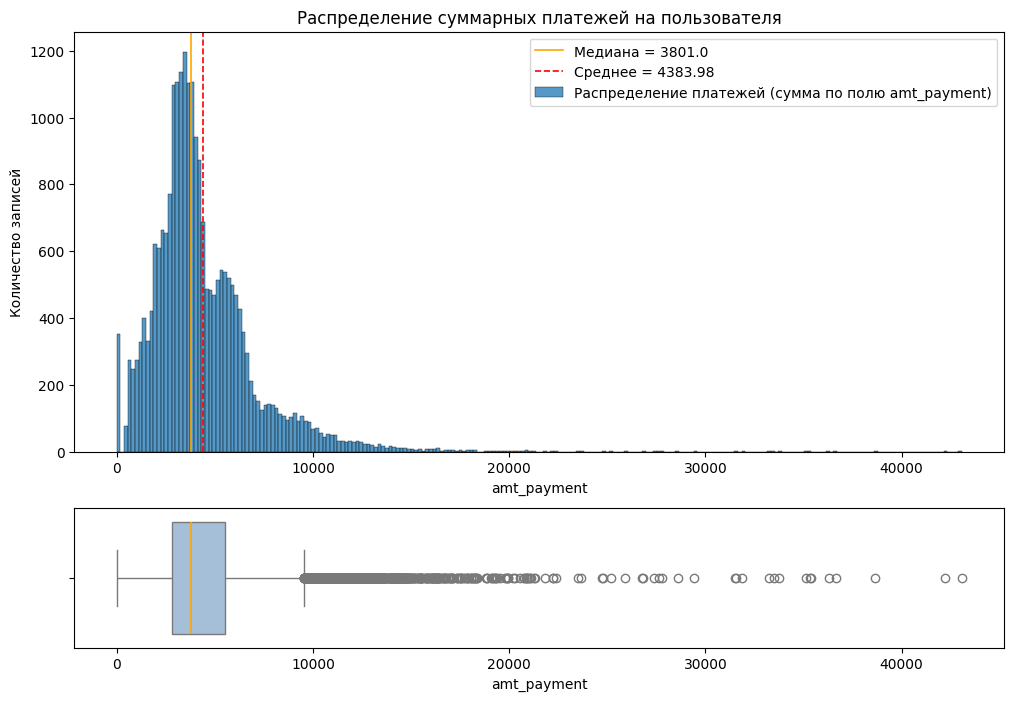

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (12, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot(means_test_df01_01['amt_payment'], ax = ax[0])
ax[0].axvline(means_test_df01_01['amt_payment'].median(), color = "orange", linewidth = 1.2)
ax[0].axvline(means_test_df01_01['amt_payment'].mean(), color = "red", linewidth = 1.2, linestyle = '--')
sns.boxplot(means_test_df01_01['amt_payment'], ax = ax[1], orient = 'h', color = 'lightblue', boxprops={"facecolor": (.3, .5, .7, .5)},
                                                                                              medianprops={"color": "orange", "linewidth": 1.2})
ax[0].legend([f'Медиана = {means_test_df01_01['amt_payment'].median()}',
              f'Среднее = {round(means_test_df01_01['amt_payment'].mean(),2)}',
              'Распределение платежей (сумма по полю amt_payment)'])
ax[0].set_ylabel('Количество записей')
ax[0].set_title('Распределение суммарных платежей на пользователя')
plt.show()

2) Проверим распределение данных при аггрегации записей о клиентах со средним значением (mean) по полю **amt_payment**

In [ ]:
means_test_df01_02 = pd.pivot_table(
               means_test_df01,
               index = 'id_client',
               values = ['id_order','id_client','amt_payment','dtime_pay','dtime_ad','nflag_test','id_trading_point','city','flag_payment'],
               aggfunc = {
               'id_order':'first',
               'id_client':'first',
               'amt_payment' : 'mean', #записи о пользователях объединяются в среднюю сумму разовых покупок
               'dtime_pay':'first',
               'dtime_ad':'first',
               'nflag_test':'first',
               'id_trading_point':'first',
               'city':'first',
               'flag_payment':'first',
               }
               ).reset_index(drop = True)
means_test_df01_02.head(5)

,amt_payment,city,dtime_ad,dtime_pay,flag_payment,id_client,id_order,id_trading_point,nflag_test
0,3052.000000,Санкт-Петербург,2022-06-03 02:47:49,2022-06-11 04:59:15,1,178561,244553,453,0
1,2439.000000,Москва,2022-06-03 02:51:21,2022-06-17 00:06:30,1,178562,169709,2652,0
2,768.000000,Санкт-Петербург,2022-06-03 02:52:10,2022-10-09 03:59:15,1,178563,121122,112,1
3,2663.000000,Санкт-Петербург,2022-06-03 03:02:56,2022-06-09 18:44:12,1,178567,249656,453,0
4,4512.333333,Москва,2022-06-03 03:05:33,2022-06-04 08:27:31,1,178568,189214,3786,1


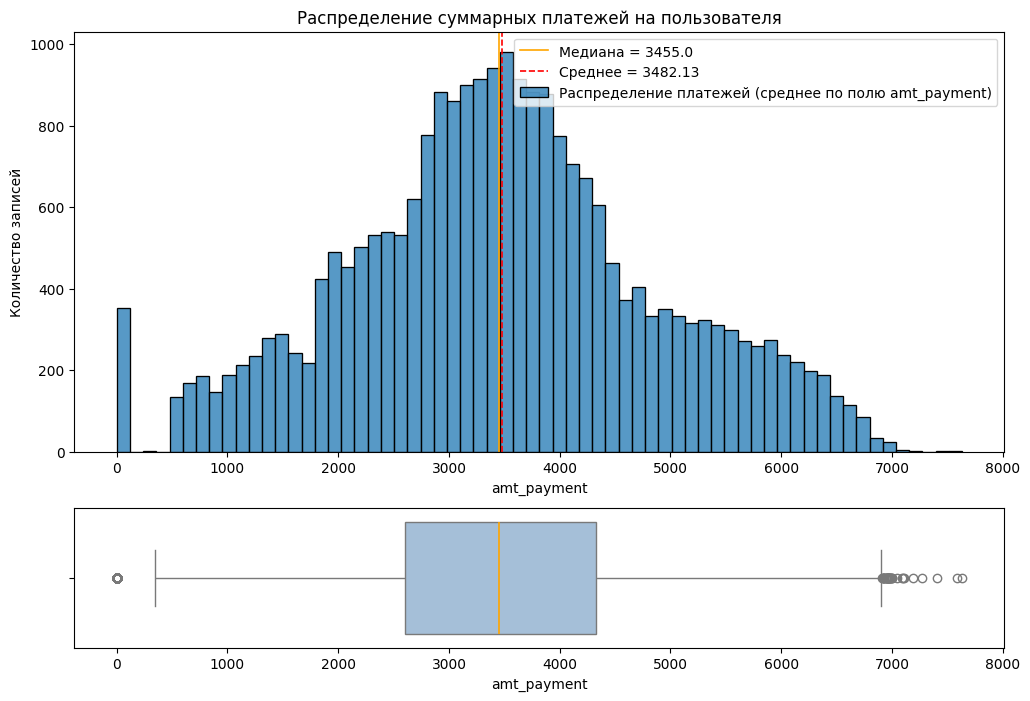

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (12, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot(means_test_df01_02['amt_payment'], ax = ax[0])
ax[0].axvline(means_test_df01_02['amt_payment'].median(), color = "orange", linewidth = 1.2)
ax[0].axvline(means_test_df01_02['amt_payment'].mean(), color = "red", linewidth = 1.2, linestyle = '--')
sns.boxplot(means_test_df01_02['amt_payment'], ax = ax[1], orient = 'h', color = 'lightblue', boxprops={"facecolor": (.3, .5, .7, .5)},
                                                                                              medianprops={"color": "orange", "linewidth": 1.2})
ax[0].legend([f'Медиана = {means_test_df01_02['amt_payment'].median()}',
              f'Среднее = {round(means_test_df01_02['amt_payment'].mean(),2)}',
              'Распределение платежей (среднее по полю amt_payment)'])
ax[0].set_ylabel('Количество записей')
ax[0].set_title('Распределение суммарных платежей на пользователя')
plt.show()

3) Проверим распределение данных при аггрегации записей о клиентах с медианой (median) по полю **amt_payment**

In [ ]:
means_test_df01_03 = pd.pivot_table(
               means_test_df01,
               index = 'id_client',
               values = ['id_order','id_client','amt_payment','dtime_pay','dtime_ad','nflag_test','id_trading_point','city','flag_payment'],
               aggfunc = {
               'id_order':'first',
               'id_client':'first',
               'amt_payment' : 'median', #записи о пользователях объединяются как медиана всех разовых покупок
               'dtime_pay':'first',
               'dtime_ad':'first',
               'nflag_test':'first',
               'id_trading_point':'first',
               'city':'first',
               'flag_payment':'first',
               }
               ).reset_index(drop = True)
means_test_df01_03.head(5)

,amt_payment,city,dtime_ad,dtime_pay,flag_payment,id_client,id_order,id_trading_point,nflag_test
0,3052.0,Санкт-Петербург,2022-06-03 02:47:49,2022-06-11 04:59:15,1,178561,244553,453,0
1,2439.0,Москва,2022-06-03 02:51:21,2022-06-17 00:06:30,1,178562,169709,2652,0
2,768.0,Санкт-Петербург,2022-06-03 02:52:10,2022-10-09 03:59:15,1,178563,121122,112,1
3,2663.0,Санкт-Петербург,2022-06-03 03:02:56,2022-06-09 18:44:12,1,178567,249656,453,0
4,3591.0,Москва,2022-06-03 03:05:33,2022-06-04 08:27:31,1,178568,189214,3786,1


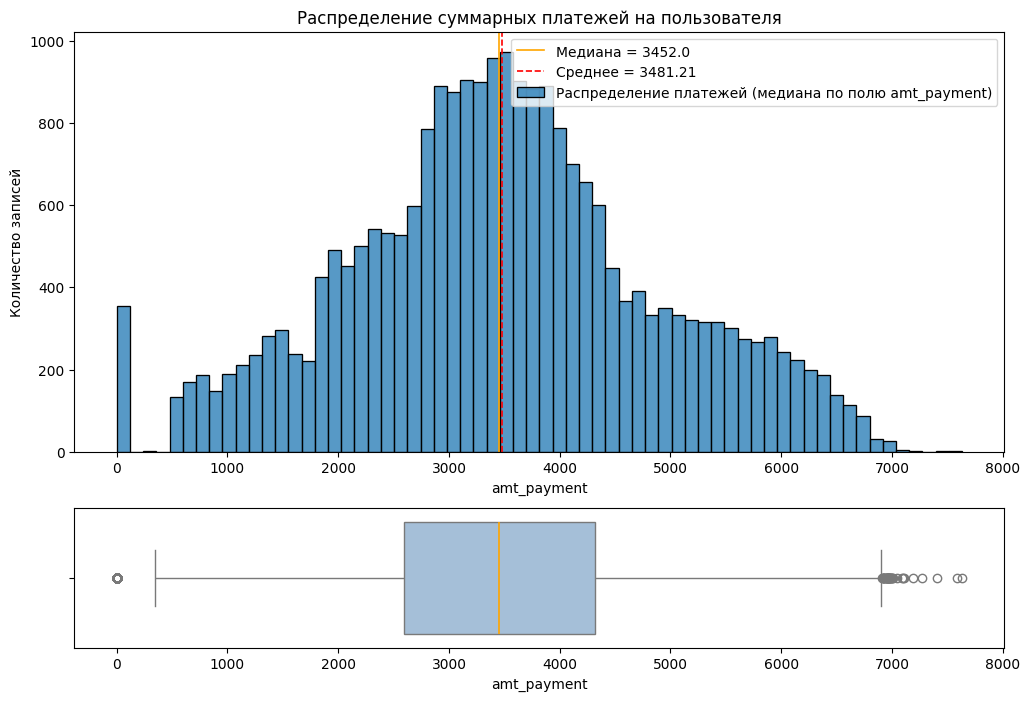

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (12, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot(means_test_df01_03['amt_payment'], ax = ax[0])
ax[0].axvline(means_test_df01_03['amt_payment'].median(), color = "orange", linewidth = 1.2)
ax[0].axvline(means_test_df01_03['amt_payment'].mean(), color = "red", linewidth = 1.2, linestyle = '--')
sns.boxplot(means_test_df01_03['amt_payment'], ax = ax[1], orient = 'h', color = 'lightblue', boxprops={"facecolor": (.3, .5, .7, .5)},
                                                                                              medianprops={"color": "orange", "linewidth": 1.2})
ax[0].legend([f'Медиана = {means_test_df01_03['amt_payment'].median()}',
              f'Среднее = {round(means_test_df01_03['amt_payment'].mean(),2)}',
              'Распределение платежей (медиана по полю amt_payment)'])
ax[0].set_ylabel('Количество записей')
ax[0].set_title('Распределение суммарных платежей на пользователя')
plt.show()

Из анализа аггрегированных данных видно, что при использовании суммы всех покупок на пользователя, у распределения появляется очень сильное правое "плечо". Суммированные записи сильно завышают среднее значение, что плохо скажется на корректности дальнейших тестов, поскольку текущая задача - проверка средних значений при помощи статистических тестов.<br>
Аггрегация по медиане и среднему дают почти одинаковый результат.<br>
Исходя из этого, объединим записи пользователей, совершивших несколько покупок по средней сумме (aggfunc = 'mean')

In [ ]:
means_test_df02 = pd.pivot_table(
               means_test_df01,
               index = 'id_client',
               values = ['id_order','id_client','amt_payment','dtime_pay','dtime_ad','nflag_test','id_trading_point','city','flag_payment'],
               aggfunc = {
               'id_order':'first',
               'id_client':'first',
               'amt_payment' : 'mean', #записи о пользователях объединяются как среднее всех разовых покупок
               'dtime_pay':'first',
               'dtime_ad':'first',
               'nflag_test':'first',
               'id_trading_point':'first',
               'city':'first',
               'flag_payment':'first',
               }
               ).reset_index(drop = True)
means_test_df02.head(5)

,amt_payment,city,dtime_ad,dtime_pay,flag_payment,id_client,id_order,id_trading_point,nflag_test
0,3052.000000,Санкт-Петербург,2022-06-03 02:47:49,2022-06-11 04:59:15,1,178561,244553,453,0
1,2439.000000,Москва,2022-06-03 02:51:21,2022-06-17 00:06:30,1,178562,169709,2652,0
2,768.000000,Санкт-Петербург,2022-06-03 02:52:10,2022-10-09 03:59:15,1,178563,121122,112,1
3,2663.000000,Санкт-Петербург,2022-06-03 03:02:56,2022-06-09 18:44:12,1,178567,249656,453,0
4,4512.333333,Москва,2022-06-03 03:05:33,2022-06-04 08:27:31,1,178568,189214,3786,1


###2.6.2 Аггрегация данных для тестов конверсии

Для тестов конверсии важен факт приведения пользователя, поэтому не требуется аггрегацию суммированием. Достаточно оставить одну строку с записью о приведенном пользователе.<br>
Для начала проверим, нет ли пользователей, попавших одновременно и в группу совершавших, и вгруппу не совершавших покупки

In [ ]:
payment_check = pd.pivot_table(conversion_test_df01,
               index = 'id_client',
               values = 'flag_payment',
               aggfunc = 'nunique'
               )
payment_check[payment_check['flag_payment'] > 1]

,flag_payment
id_client,


Таких пользователей нет, данные верны. Оставим только первые записи о приведенных пользователях

In [ ]:
conversion_test_df02 = conversion_test_df01.drop_duplicates(subset = ['id_client'], keep = 'first')
print(f'Было записей {conversion_test_df01.shape[0]}\nОсталось записей {conversion_test_df02.shape[0]}')

Было записей 51505
Осталось записей 45305


##2.7 Визуализации полученных данных

Рассмотрим количество торговых точек по городам

In [ ]:
tp_list = {}
for city in means_test_df02['city'].unique():
    tp_list[city] = len(means_test_df02[means_test_df02['city'] == city]['id_trading_point'].unique())
tp_series = pd.Series(tp_list).rename('Количество торговых точек')
tp_series

,Количество торговых точек
Санкт-Петербург,11
Москва,11
Саратов,2
Тольятти,1
Владимир,1
Мурманск,2
Красноярск,5
Казань,6
Самара,4
Волгоград,1


In [ ]:
palette = sns.light_palette("seagreen", n_colors= len(tp_series), reverse = True)
palette

[(np.float64(0.1803921568627451),
  np.float64(0.5450980392156862),
  np.float64(0.3411764705882353)),
 (np.float64(0.2327028890700567),
  np.float64(0.5737649077866657),
  np.float64(0.3827585394451709)),
 (np.float64(0.28501362127736835),
  np.float64(0.602431776357645),
  np.float64(0.42434060830210657)),
 (np.float64(0.33732435348467993),
  np.float64(0.6310986449286244),
  np.float64(0.4659226771590422)),
 (np.float64(0.39254123748128666),
  np.float64(0.6613581173091027),
  np.float64(0.5098148609524742)),
 (np.float64(0.4448519696885983),
  np.float64(0.6900249858800821),
  np.float64(0.5513969298094099)),
 (np.float64(0.49716270189590983),
  np.float64(0.7186918544510614),
  np.float64(0.5929789986663455)),
 (np.float64(0.5523795858925166),
  np.float64(0.7489513268315398),
  np.float64(0.6368711824597776)),
 (np.float64(0.6046903180998282),
  np.float64(0.7776181954025191),
  np.float64(0.6784532513167132)),
 (np.float64(0.6570010503071397),
  np.float64(0.8062850639734985),
  np.float64(0.7200353201736488)),
 (np.float64(0.7093117825144515),
  np.float64(0.834951932544478),
  np.float64(0.7616173890305844)),
 (np.float64(0.7645286665110581),
  np.float64(0.8652114049249562),
  np.float64(0.8055095728240165)),
 (np.float64(0.8168393987183697),
  np.float64(0.8938782734959356),
  np.float64(0.8470916416809521)),
 (np.float64(0.8691501309256814),
  np.float64(0.9225451420669151),
  np.float64(0.8886737105378878)),
 (np.float64(0.921460863132993),
  np.float64(0.9512120106378944),
  np.float64(0.9302557793948234))]

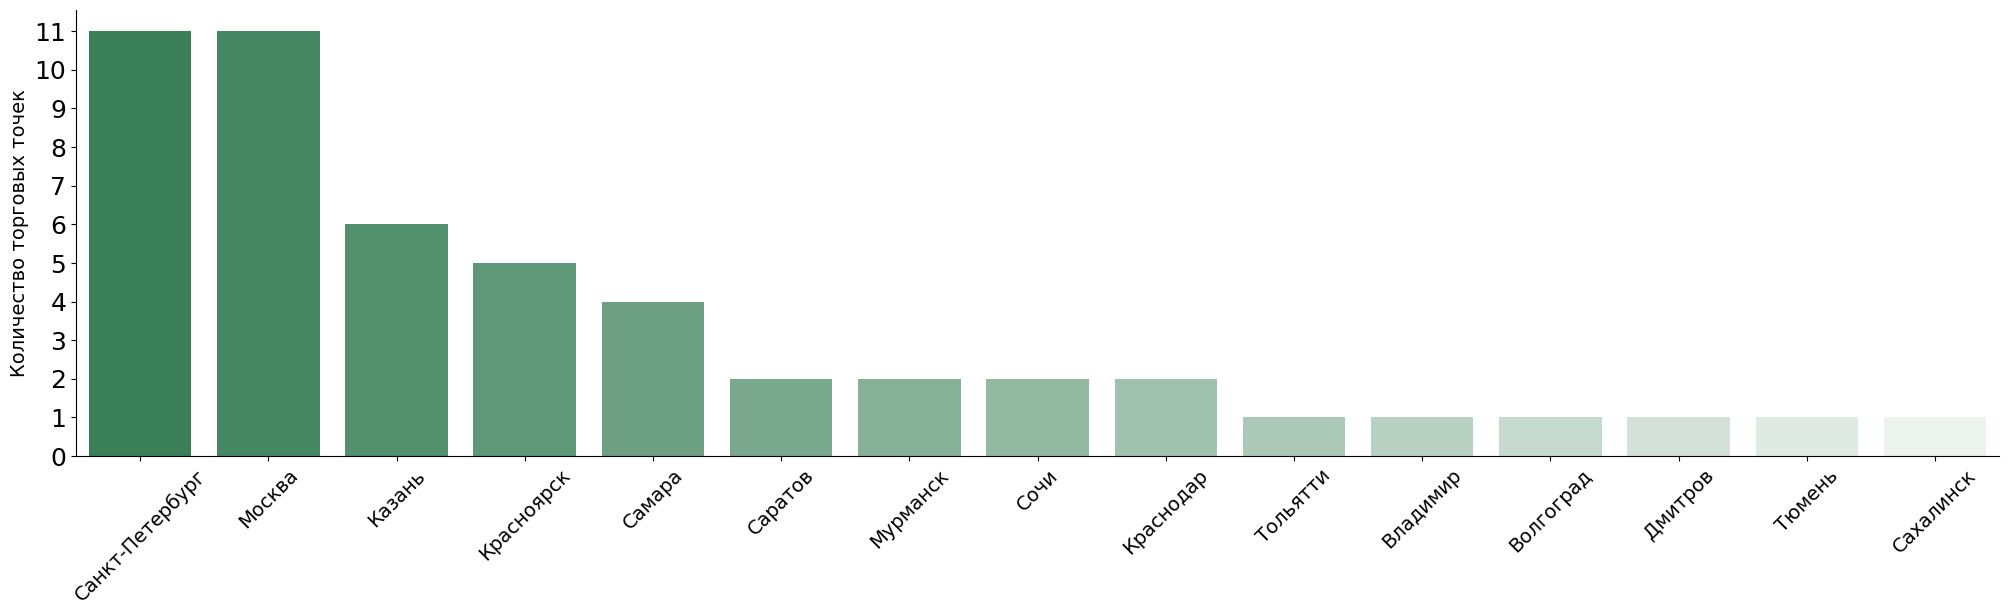

In [ ]:
sns.catplot(tp_series.sort_values(ascending=False), kind = 'bar', aspect = 4,  palette = palette)
plt.yticks(range(0,12,1), size=18)
plt.xticks(rotation = 45, size=14)
plt.ylabel('Количество торговых точек', fontsize = 14)
plt.show()

Рассмотрим количество покупателей по городам

In [ ]:
cl_list = {}
for city in means_test_df02['city'].unique():
    cl_list[city] = len(means_test_df02[means_test_df02['city'] == city]['id_client'].unique())
cl_series = pd.Series(cl_list).rename('Количество торговых точек')
cl_series

,Количество торговых точек
Санкт-Петербург,4483
Москва,6464
Саратов,1256
Тольятти,222
Владимир,592
Мурманск,920
Красноярск,3368
Казань,2449
Самара,966
Волгоград,796


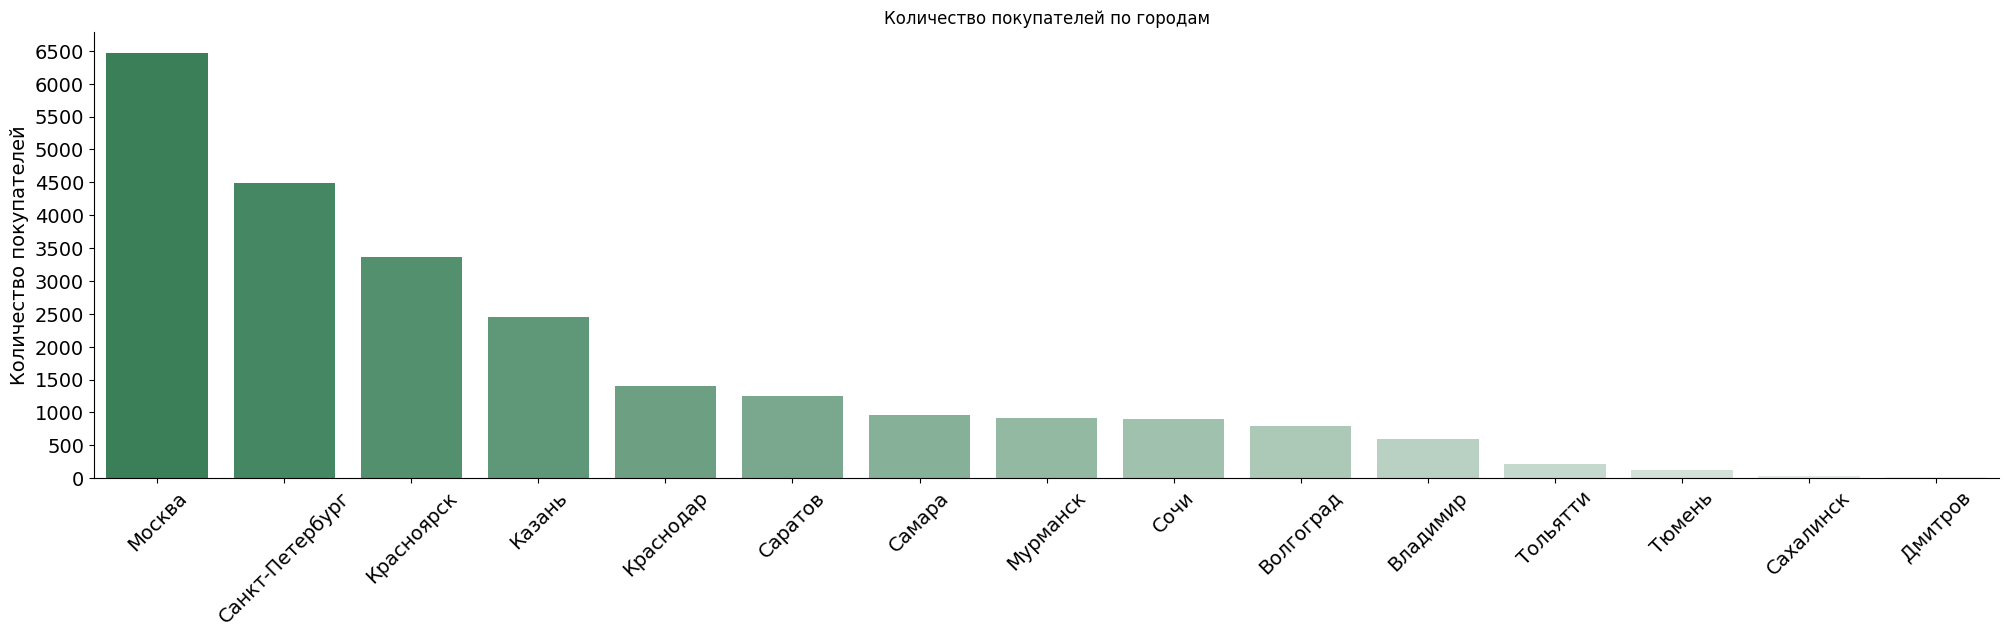

In [ ]:
sns.catplot(cl_series.sort_values(ascending=False), kind = 'bar', aspect = 4,  palette = palette)
plt.yticks(range(0,7000,500), size=14)
plt.xticks(rotation = 45, size=14)
plt.ylabel('Количество покупателей', fontsize = 14)
plt.title('Количество покупателей по городам')
plt.show()

Рассмотрим число покупателей в среднем на точку

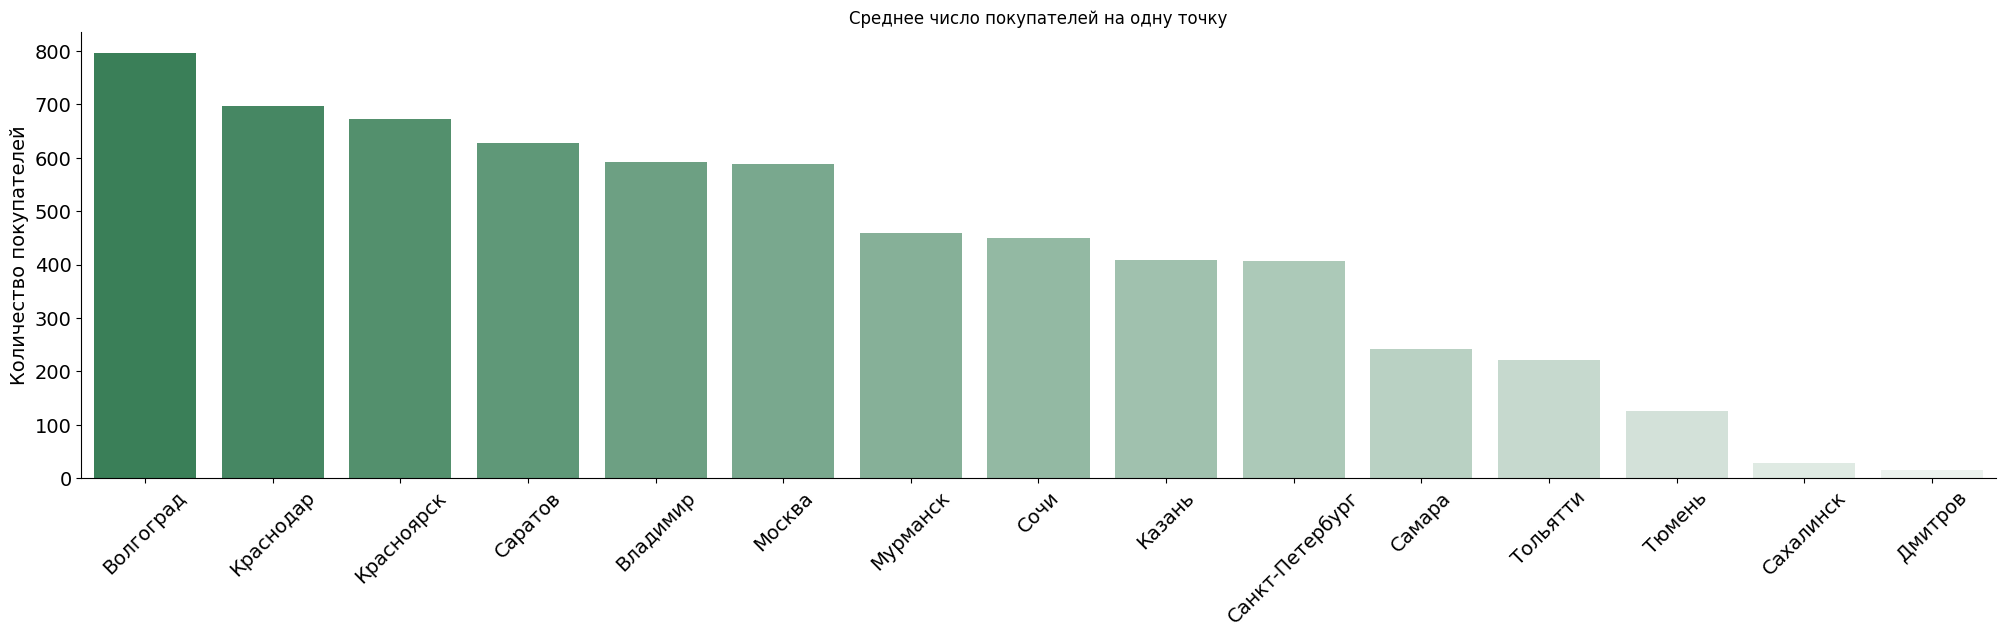

In [ ]:
sns.catplot((cl_series/tp_series).sort_values(ascending=False), kind = 'bar', aspect = 4,  palette = palette)
plt.yticks(size=14)
plt.xticks(rotation = 45, size=14)
plt.ylabel('Количество покупателей', fontsize = 14)
plt.title('Среднее число покупателей на одну точку')
plt.show()

Рассмотрим средние платежи по городам

In [ ]:
avg_pay_by_city_list = {}
for city in means_test_df02['city'].unique():
    avg_pay_by_city_list[city] = (means_test_df02[means_test_df02['city'] == city]['amt_payment'].mean())
avg_pay_by_city_list = pd.Series(avg_pay_by_city_list).rename('Средний платеж по городу')
avg_pay_by_city_list

,Средний платеж по городу
Санкт-Петербург,3418.395981
Москва,3577.645039
Саратов,3413.123275
Тольятти,3404.263514
Владимир,3498.145101
Мурманск,3412.451304
Красноярск,3447.745210
Казань,3593.908243
Самара,3377.599120
Волгоград,3332.018740


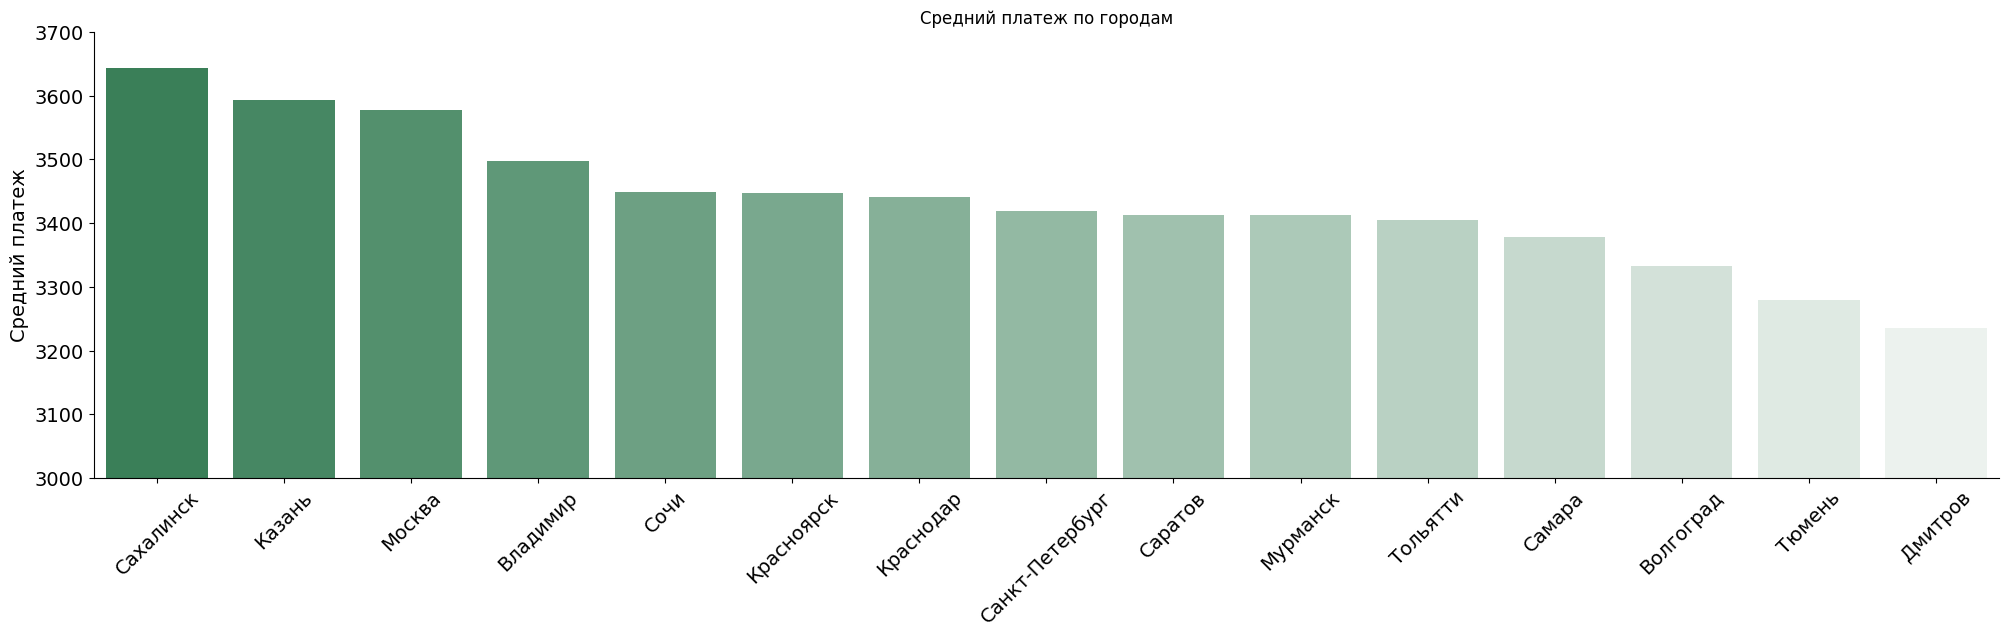

In [ ]:
sns.catplot(avg_pay_by_city_list.sort_values(ascending=False), kind = 'bar', aspect = 4,  palette = palette)
plt.yticks(size=14)
plt.xticks(rotation = 45, size=14)
plt.ylim(bottom = 3000, top = 3700)
plt.title('Средний платеж по городам')
plt.ylabel('Средний платеж', fontsize = 14)
plt.show()

**Выводы анализа данных по городам:**


1.  Наибольшее число покупателей приходится на города: Москва, Казань, Санкт-Петербург и Краснодар
2.  Наибольшее количество точек расположено в городах: Москва, Казань, Санкт-Петербург, Красноярск
3. Волгоград, Краснодар, Красноярск и Саратов лидируют по числу покупателей, приходящихся на одну точку
4. Наибольший средний чек зафиксирован в городах: Сахалинск, Казань, Москва, Владимир



Посмотрим на баланс данных о суммах платежей по торговым точкам

Средний платеж среди всех точек, за редким исключением, держится на уровне 3200 - 3700 рублей

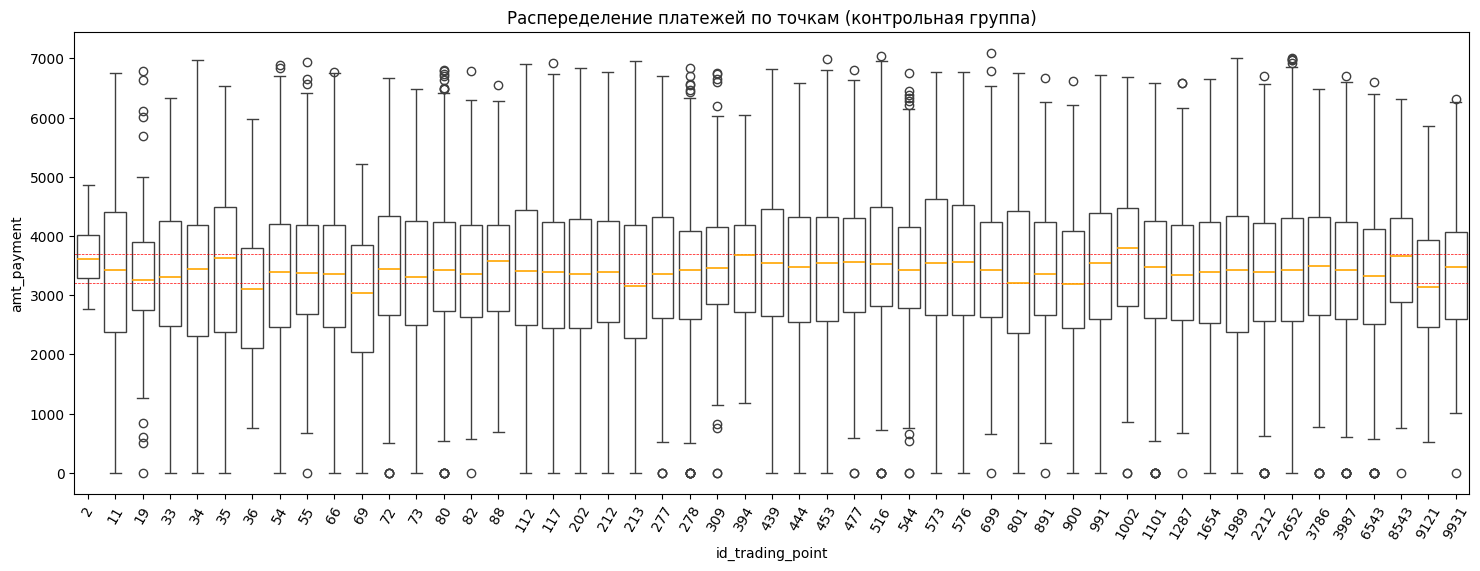

In [ ]:
plt.figure(figsize=(18, 6))
sns.boxplot(means_test_df02[means_test_df02['nflag_test'] == 0], x ='id_trading_point', y = 'amt_payment', boxprops={"facecolor": 'w'},
                                                                       medianprops={"color": "orange", "linewidth": 1.2})
plt.axhline(y = 3200, linestyle = '--', color = 'red', linewidth = 0.5)
plt.axhline(y = 3700, linestyle = '--', color = 'red', linewidth = 0.5)
plt.xticks(rotation=60)
plt.title('Распеределение платежей по точкам (контрольная группа)')
plt.show()

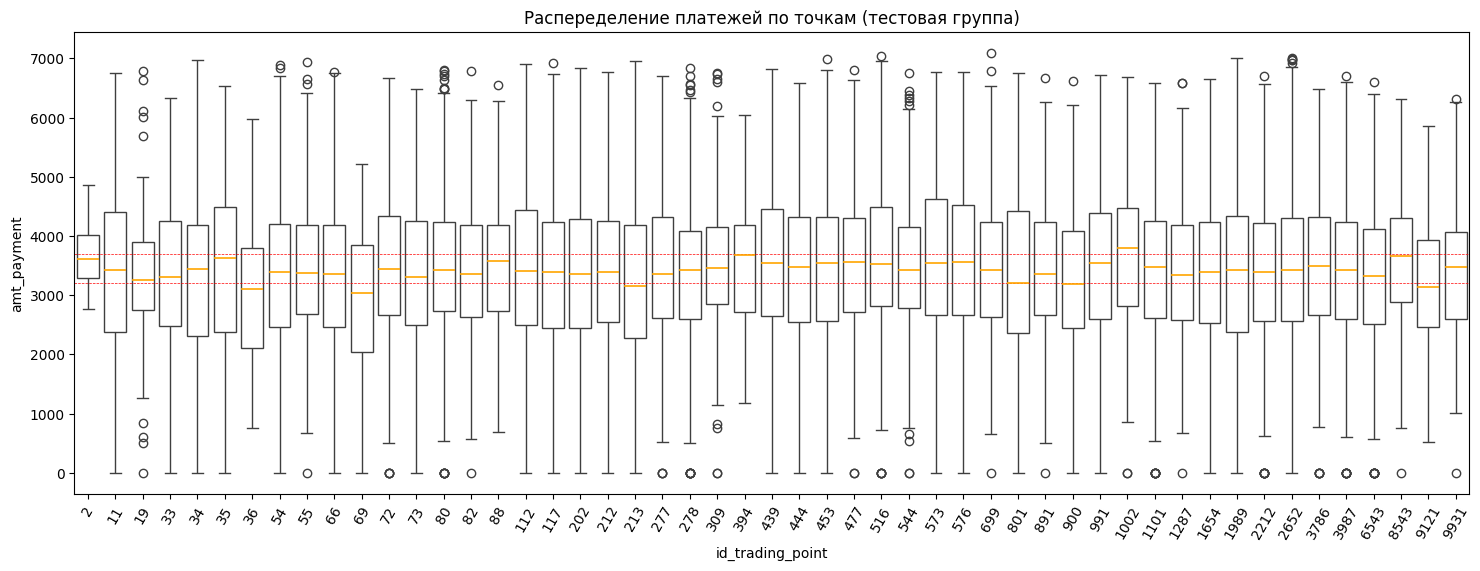

In [ ]:
plt.figure(figsize=(18, 6))
sns.boxplot(means_test_df02[means_test_df02['nflag_test'] == 0], x ='id_trading_point', y = 'amt_payment', boxprops={"facecolor": 'w'},
                                                                       medianprops={"color": "orange", "linewidth": 1.2})
plt.axhline(y = 3200, linestyle = '--', color = 'red', linewidth = 0.5)
plt.axhline(y = 3700, linestyle = '--', color = 'red', linewidth = 0.5)
plt.xticks(rotation=60)
plt.title('Распеределение платежей по точкам (тестовая группа)')
plt.show()

**Вывод:**<br>
Визуализации не дают возможности приблизительно оценить отличия в средних чеках тостовой и контрольной групп по торговым точкам. Дальнейшие выводы будут сделаны на основе статистических тестов

#3 Проектирование статистических тестов

##3.1 Сравнение конверсий



###3.1.1. Точный тест Фишера

Точный тест Фишера
**Точный тест Фишера (или просто тест Фишера)** - это непараметрический критерий, аналогичный тесту хи-квадрат, но его можно применять с небольшим количеством данных или в случае разреженного распределения данных, которые не
подходят под требования хи-квадрата. Тест Фишера основан на гипергеометрическом распределении и рассчитывает точную вероятность наблюдения такого
распределения, как в данных, или более экстремального.<br>
Формула

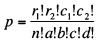
<br>
Где r1 и r1 - суммы числа исходов по строкам, c1 и c2 - суммы числа исходов по колонкам, а n - общее число наблюдений в таблице 2x2:<br>
<br>
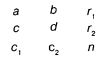

Пример такой таблицы для Москвы

In [ ]:
conv_test_col_0 = conversion_test_df02[conversion_test_df02['city'] == 'Москва']['nflag_test']
conv_test_col_1 = conversion_test_df02[conversion_test_df02['city'] == 'Москва']['flag_payment']

In [ ]:
pd.crosstab(conv_test_col_0, conv_test_col_1, margins = True).rename(columns = {0:'Покупка не совершена', 1: 'Покупка совершена'})

flag_payment,Покупка не совершена,Покупка совершена,All
nflag_test,,,
0,3128,3096,6224
1,2753,3368,6121
All,5881,6464,12345


Зададим функцию, принимающую таблицу 2x2 и выдающую значения точного теста Фишера и уровень значимости

In [ ]:
def fisher_exact_test(rc_tab):
  F, p_value_f = fisher_exact(rc_tab)
  return F, p_value_f

###3.1.2 Тест Хи-квадрат

**Критерий хи-квадрат** - это один из наиболее распространенных способов изучения связей между двумя и более категориальными переменными. Проведение этого теста включает расчет статистики хи-квадрат и ее сравнение с распределением
хи-квадрат, чтобы найти вероятность данного результата критерия.

In [ ]:
def chi_squared_test(rc_tab):
  chi2, p_value_chi = chi2_contingency(rc_tab_abs)[0:1]
  return chi2, p_value_chi

Для проведения теста хи-квадрат требуется соблюдение достаточного количества наблюдений в каждой их выборок (тест и контроль), зависящий от дисперсий данных в группах и **MDE** - минимального обнаруживаемого эффекта, в нашем случае изменения конверсии<br>
Рассчитать ее можно по формуле:<br>
\begin{equation*}
n = \frac {2σ^{2} (Z_{1-β}   + Z_{α/2})^{2}}{MDE^{2}}
\end{equation*}

Напишем функцию, реализующую указанную формулу используя модуль **statsmodels.stats.api**

In [ ]:
def sample_size_calculator(base_conversion, mde, power, alpha=0.05):
    effect_size = sms.proportion_effectsize(base_conversion, base_conversion + mde)
    sample_size = sms.NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1)
    return sample_size

###3.1.3 Формирование функции подбора теста

Поскольку тест хи-квадрат требует достаточного размера выборки, на входе теста нужно проверять количество наблюдений в тестовой и контрольной группах. Там где наблюдений недостаточно - используем критерий Фишера<br>
Реализуем класс выполнения теста конверсии, который по полученным данным формирует таблицу 2x2, проверяет достаточность выборок, и проводит тест Фишера там, где для Хи-квадрат недостаточно наблюдений.<br>
Обозначенные выше функции используем как методы класса

In [ ]:
class Conversion_testing:
  def __init__(self, conv_test_col_0, conv_test_col_1, mde, alpha = 0.05, power = 0.8):
    self.conv_test_col_0 = conv_test_col_0
    self.conv_test_col_1 = conv_test_col_1
    self.__alpha = alpha
    self.__power = power
    self.__mde = mde

  def __get_rc_tab(self):
    """
    Получаем таблицу из входящих данных
    """
    self.__rc_tab = pd.crosstab(self.conv_test_col_0, self.conv_test_col_1).rename(columns = {0:'Покупка не совершена', 1: 'Покупка совершена'})
    return self.__rc_tab

  def __calculate_sample_size(self):
    """
    Подсчет необходимой длины выборки
    """
    self.__base_conversion = self.__rc_tab.loc[0,'Покупка совершена']/(self.__rc_tab.loc[0,'Покупка совершена'] + self.__rc_tab.loc[0,'Покупка не совершена'])
    self.__effect_size = sms.proportion_effectsize(self.__base_conversion, self.__base_conversion + self.__mde)
    self.__sample_size = sms.NormalIndPower().solve_power(self.__effect_size, power=self.__power, alpha=self.__alpha, ratio=1)
    return self.__sample_size
  def __choose_conversion_test(self):
     """
     Определение максимально возможной длины выборки из имеющихся данных.
     Определяем основываясь на том, что в тесте группы должны иметь одинаковый размер
     Соответственно, минимальное количество данных в группе 0 или группе 1, будет максимальным размером выборки для обоих групп
     """
     self.__max_data_size = min((self.__rc_tab.loc[0,'Покупка совершена'] + self.__rc_tab.loc[0,'Покупка не совершена']),
                                 (self.__rc_tab.loc[1,'Покупка совершена'] + self.__rc_tab.loc[1,'Покупка не совершена'])
                                 )
     #Если выборка слишком мала для теста Пирсона, выбирается тест Фишера
     if self.__sample_size >= self.__max_data_size:
        self.__test_name = 'F-test'
     else:
        self.__test_name = 'Chi2'

  def get_test(self):
    """
    Выбор теста и запись полученных значений, исходя из условий достаточности выборки
    Если выборка слишком мала для теста Пирсона, выбирается тест Фишера по ранее присвоенному test_name
    """
    #по порядку инициируем приватные методы класса
    self.__rc_tab = self.__get_rc_tab()
    self.__sample_size = self.__calculate_sample_size()
    self.__choose_conversion_test()
    self.__len_control = self.__rc_tab.loc[0,'Покупка совершена'] + self.__rc_tab.loc[0,'Покупка не совершена']
    self.__len_test = self.__rc_tab.loc[1,'Покупка совершена'] + self.__rc_tab.loc[1,'Покупка не совершена']
    #разность конверсий вычислим как разность отношений совершенных покупок в тестовой и контрольной группах к их размерам
    self.__conv_delta = self.__rc_tab.loc[1,'Покупка совершена']/self.__len_test - self.__rc_tab.loc[0,'Покупка совершена']/self.__len_control

    #выполняем выбранный тест
    if self.__test_name == 'F-test':
      F, p_value_ftest = stats.fisher_exact(self.__rc_tab)[0:2]
      self.conv_test_data = {'Размер тест.': self.__len_test,
                             'Размер контроль.': self.__len_control,
                             'Статистика':  self.__test_name,
                             'Значение': F,
                             'H0': (lambda p_value_ftest: 'Опровергается' if p_value_ftest < self.__alpha else 'Верна')(p_value_ftest),
                             'p-value':p_value_ftest, 'α': self.__alpha,
                             'Изменение конверсии': (lambda p_value_ftest: f'{round(self.__conv_delta*100,2)}%' if p_value_ftest < self.__alpha else 'Не обнаружено')(p_value_ftest)}
    else:
      chi2, p_value_chi = stats.chi2_contingency(self.__rc_tab)[0:2]
      self.conv_test_data = {'Размер тест.': self.__len_test,
                             'Размер контроль.': self.__len_control,
                             'Статистика':  self.__test_name,
                             'Значение': chi2,
                             'H0': (lambda p_value_chi: 'Опровергается' if p_value_chi < self.__alpha else 'Верна')(p_value_chi),
                             'p-value':p_value_chi, 'α': self.__alpha,
                             'Изменение конверсии': (lambda p_value_chi: f'{round(self.__conv_delta*100,2)}%' if p_value_chi < self.__alpha else 'Не обнаружено')(p_value_chi)}
    return self.conv_test_data


Пример работы для Москвы

In [ ]:
conv_test_col_0 = conversion_test_df02[conversion_test_df02['city'] == 'Москва']['nflag_test']
conv_test_col_1 = conversion_test_df02[conversion_test_df02['city'] == 'Москва']['flag_payment']
conv_test_result = Conversion_testing(conv_test_col_0, conv_test_col_1, 0.05).get_test()
pd.Series(conv_test_result).rename('Москва')

,Москва
Размер тест.,6121
Размер контроль.,6224
Статистика,Chi2
Значение,34.288942
H0,Опровергается
p-value,0.0
α,0.05
Изменение конверсии,5.28%


##3.2 Сравнение средних платежей

Нулевая гипотеза согласно задаче проведения тестирования - выявление наличия (отсутствия) различий между средними чеками в тестовой и контрольной группе<br>
H0 - средние чеки равны, новый тип уведомлений не повлиял на изменение среднего чека<br>
H1 - средние чеки не равны, новый тип уведомлений привел к изменению среднего чека<br>
<br>
Для проведения статистических тестов по сравнению средних двух выборок рассмотрим три метода:
1. **Тест Манна-Уитни**. Непараметрический тест, не требующий нормальности распределения данных, хорошо работающий также на малых выборках, что полезно ввиду наличия городов и отдельных точек, с небольшим числом клиентов
2. **Двувыборочный тест Стьюдента (Уэлча)** - статистический метод сравнения средних значений двух выборок, основанный на сравнении выборочных средних и выборочных дисперсий. Требует нормальности распределения, а также равенства дисперсий. В случае неравенства дисперсий применим модификацию - тест Уэлча. Предварительную проверку равенства дисперсий проведем посредством теста Левене.
3. **Бутстреп** по разнице средних. Метод исследования распределения статистик, основанный на многократной генерации выборок методом Монте-Карло на базе имеющейся выборки. Распределения статистики при достаточно большом числе повторений близки к нормальному, что позволяет делать выводы согласно критериям нормальных распределений

Ввиду большого различия числа наблюдений на разных сегментах, отдельные тесты могут лучше работать на одних, и хуже на других сегментах. Проведем все три теста по каждому сегменту и сделаем выводы, исходя из их согласованности

###3.1.1 Тест Манна-Уитни

1. Используем метод **mannwhitneyu** модуля **stats**<br>
2. Метод реализует вычисление самой статистики (**test_value_mw**) и вероятности получения подобного результата (**p_value_mw**) на основе полученных значений<br>
3. Изначально, тест Манна-Уитни требует сравнения с таблицами критических значений, для оценки результата. Однако, вычисление p_value позволит избежать таблиц и автоматизировать процесс.<br>
4. Оценку результата проведем сравнением **p_value_mw** и уровня значимости **alpha**

In [ ]:
def mann_whitney_test(sample_0, sample_1, alpha):
    test_value_mw, p_value_mw = stats.mannwhitneyu(sample_0, sample_1)
    chosen_test = 'Mann-Whitney'
    test_results_mw = {'Mann-Whitney': test_value_mw,
                       'pvalue_MWtest': p_value_mw,
                       'Значимость MW': (lambda p_value_mw: True if p_value_mw < alpha else False)(p_value_mw)}
    return test_results_mw


###3.2.2 Тест Стьюдента (тест Уэлча)

1. Используем метод **stats.ttest_ind** модуля **stats**<br>
2. Метод реализует вычисление самой статистики(**test_value_t**) и вероятности получения подобного результата (**p_value**) на основе полученных значений
3. Оценку результата проведем сравнением **p_value_t** и уровня значимости **alpha**<br>
4. Предварительную оценку равенства дисперсий проведем посредством теста Левене, используя метод **stats.levene**
5. Критическое значение теста Левене определяется построением распределения Фишера **stats.f** для степени свободы в объемах n1-1 и n2-1 (n1,n2 - размеры выборок) и вычисления значения функции веротности при уровне значимости **alpha**

In [ ]:
def t_test(sample_0, sample_1, alpha):

    levene_test, p_val_levene = stats.levene(sample_0, sample_1)
    # сформируем распределение Фишера для автоматизированного подбора критического значения
    fisher_dist = stats.f(len(sample_0)-1, len(sample_1)-1)
    fisher_crit = fisher_dist.ppf(1-alpha)

    if levene_test < fisher_crit and p_val_levene > alpha:
       chosen_test = 'Student' #Равенство дисперсий по результатам теста Левене не отвергаем. Проводим тест Стьюдента, для выборок с равной дисперсией
    else:
      chosen_test = 'Welch' #Равенство дисперсий по результатам теста Левене отвергаем. Проводим тест Уэлча, для выборок с неравной дисперсией

    test_value_t, p_value_t = stats.ttest_ind(
        sample_0.values,
        sample_1.values,
        equal_var = (lambda chosen_test: True if chosen_test == 'Student' else False)(chosen_test))
    test_results_t = {'t-test': test_value_t,
                      'pvalue_ttest': p_value_t,
                      'Значимость t': (lambda p_value_t: True if p_value_t < alpha else False)(p_value_t)}
    return test_results_t

###3.3.3 Bootstrap

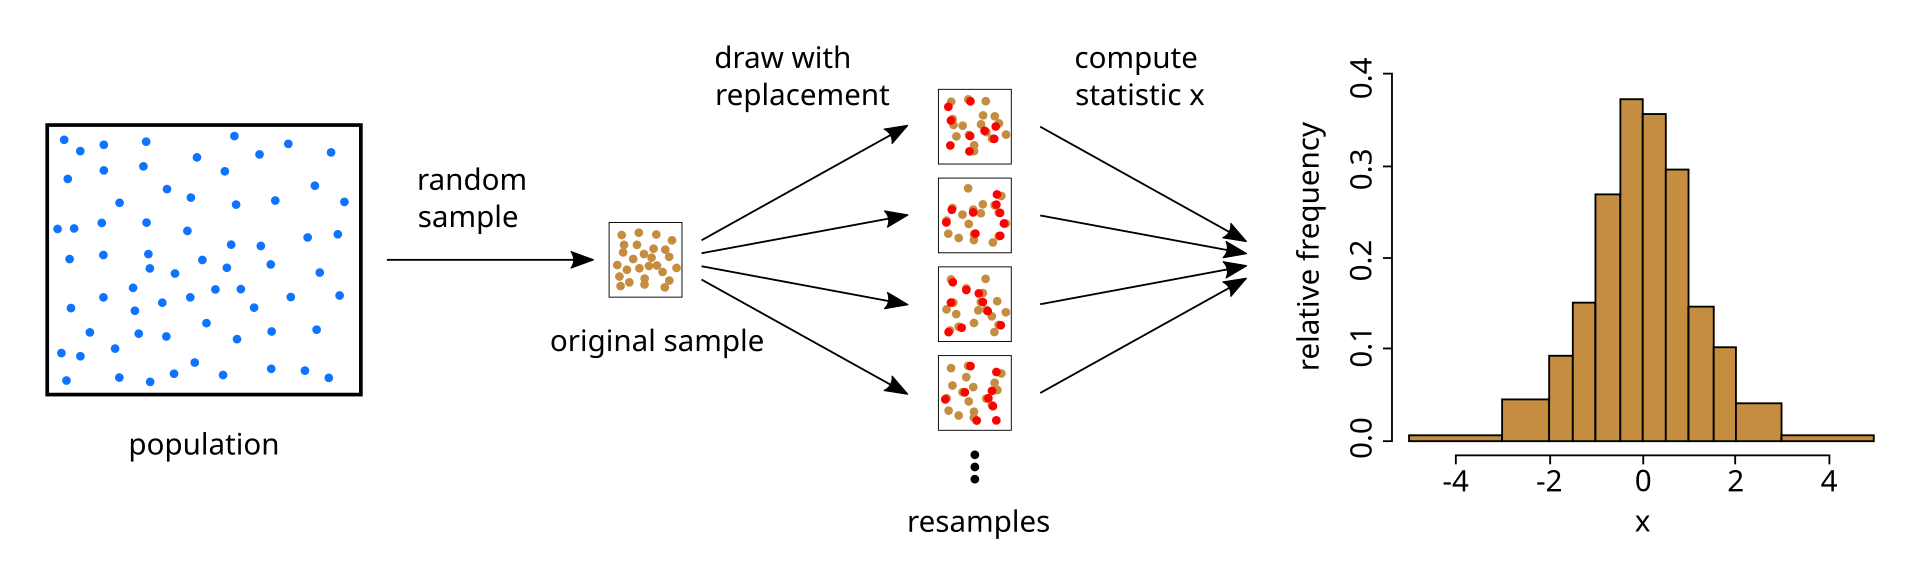

Алгоритм проверки гипотез с помощью бутстрепа:<br>

1. Генерируем пару подвыборок, каждая в размере исходной,<br>
из исходных данных контрольной и экспериментальной групп<br>
используя случайный выбор с возвращением;

2. Считаем нужную метрику;

3. Повторяем шаги 1-2 от 1000 до 10000 раз;

4. Строим распределение и доверительный интервал с уровнем значимости **alpha**;

5. Если значение H0 не принадлежит доверительному интервалу, то отличия статистически значимы на уровне значимости **alpha**.

In [ ]:
class Bootstrap_means_test:
  def __init__(self, values_a, values_b, alpha = 0.05):
    self.values_a = values_a
    self.values_b = values_b
    self.alpha = alpha

  def get_normal_ci(self, bootstrap_stats, pe, alpha):
    """Нормальный доверительный интервал."""
    self.__z = stats.norm.ppf(1 - alpha / 2)
    self.__std = np.std(self.__bootstrap_stats)

    #нижняя и верхняя границы ДИ
    #ci = point_estimate +- z(1-a/2) * std
    self.__ci_lower_bound = self.__point_estimate - self.__z * self.__std
    self.__ci_upper_bound = self.__point_estimate + self.__z * self.__std
    return self.__ci_lower_bound, self.__ci_upper_bound

  def get_boot(self, n_samples, is_full_results = False):
    """Вид возвращаемого результата
       is_full_results = False - возвращает только значение True или False
       в зависимости от того, попадает ли нулевая гипотеза в дов.интервал
       в данной реализации - попадает ли в дов.интервал 0,
       что говорит, об отсутствии значимой разницы средних
       is_full_results = True - возвращает значимость, разницу наблюдаемых средних (point_estimate),
       границы дов.интервала,
       значения распределения в виде списка и графики
    """
    self.__is_full_results = is_full_results

    """Наблюдаемая виличина, для данной реализации - разность средних
       она же точечная оценка для построения доверительного интервала"""
    self.__point_estimate = np.mean(self.values_b) - np.mean(self.values_a)

    """Реализация бустрепа
       Из исходных групп отбираются значения с возвращением
       (одно число может быть использовано несколько раз)
       Повторяется процедура n_samples раз, не менее 10000
       Для кадой пары считается разница средних и записывается
       В атрибут bootsrap_stats. Множество значений этого атрибута
       Формируют распеределение для искомой величины - разницы средних
       Распределение близко к нормальному, ввиду чего можно построить доверительный интервал
    """
    self.__bootstrap_stats = []
    for i in tqdm(range(n_samples)):
      self.__bootstrap_values_a = np.random.choice(self.values_a, len(self.values_a), True)
      self.__bootstrap_values_b = np.random.choice(self.values_b, len(self.values_b), True)
      self.__means_delta = np.mean(self.__bootstrap_values_b) - np.mean(self.__bootstrap_values_a)
      self.__bootstrap_stats.append(self.__means_delta)

    self.__normal_ci = self.get_normal_ci(self.__bootstrap_stats, self.__point_estimate, self.alpha)

    self.__full_results = {
            'diff': self.__point_estimate,
            'Доверительный интервал': self.__normal_ci,
            'Значимость bt': not (self.__normal_ci[0] < 0 < self.__normal_ci[1]),
            }
    self.__short_results = {'Значимость bt': not (self.__normal_ci[0] < 0 < self.__normal_ci[1])}

    if self.__is_full_results == True:
      self.__plot = self.__plot_bootstrap_results(self.__full_results,
                                           self.__bootstrap_stats,
                                           self.values_a, self.values_b)

      return self.__full_results, self.__bootstrap_stats, self.__plot
    else:
      return self.__short_results

  def __plot_bootstrap_results(self, boot_results, distribution, values_a, values_b):
    """
    График распределения теста на основе бустрепа и распределение данных в группах
    """
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))


    ax1.hist(distribution, bins=50, alpha=0.7, edgecolor='black')
    ax1.axvline(boot_results['diff'], color='red', linestyle='--',
                linewidth=2, label=f'Наблюдаемый diff = {boot_results['diff']:.3f}')
    ax1.axvline(boot_results['Доверительный интервал'][0], color='orange', linestyle=':',
                linewidth=2, label=f'{(1-self.alpha)*100}% доверительный интервал')
    ax1.axvline(boot_results['Доверительный интервал'][1], color='orange', linestyle=':', linewidth=2)
    ax1.set_xlabel('Разность средних (diff)')
    ax1.set_ylabel('Частота')
    ax1.set_title('Распределение разности средних значений')
    ax1.legend()
    ax1.grid(alpha=0.3)


    positions = [1, 2]
    ax2.boxplot([values_a, values_b], positions=positions, labels=['Контроль', 'Тест'])
    ax2.scatter(np.random.normal(1, 0.05, len(values_a)), values_a, alpha=0.6, s=30)
    ax2.scatter(np.random.normal(2, 0.05, len(values_b)), values_b, alpha=0.6, s=30)
    ax2.set_ylabel('Значения')
    ax2.set_title('Исходные данные')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



Для демонстрации работы бутстрепа проведем несколько тестов на разных сегментах <br>
H0 - средние тестовой и контрольной группы равны<br>
H1 - средние не равны, есть статистически значимые отличия<br>

  0%|          | 0/10000 [00:00<?, ?it/s]

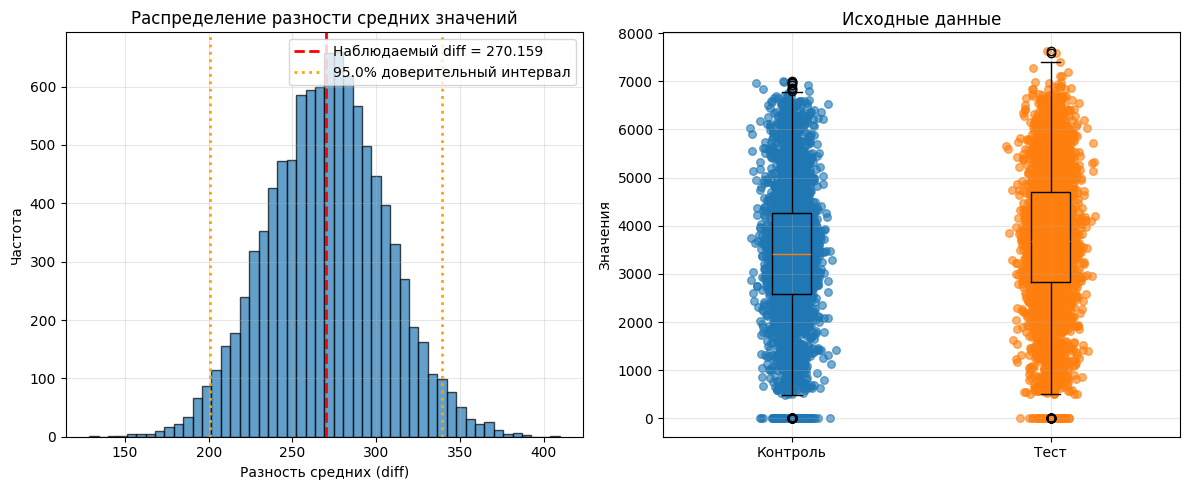

In [ ]:
#тест по Москве
#выведем полный результат. В этом окне - график, и отдельно значения
values_0 = means_test_df02[(means_test_df02['city'] == 'Москва') & (means_test_df02['nflag_test'] == 0)]['amt_payment']
values_1 = means_test_df02[(means_test_df02['city'] == 'Москва') & (means_test_df02['nflag_test'] == 1)]['amt_payment']
means_test_demonstration = Bootstrap_means_test(values_0, values_1, alpha = 0.05)
means_test_res, means_test_distribution, means_test_plot = means_test_demonstration.get_boot(n_samples = 10000, is_full_results = True)
means_test_plot

In [ ]:
means_test_res

{'diff': np.float64(270.1585991759898),
 'Доверительный интервал': (np.float64(200.8228760085994),
  np.float64(339.49432234338025)),
 'Значимость bt': True}

Бутстреп показал, что 0 - за пределами доверительного интервала.<br>
Значит, H0 для сегмента "Москва вцелом" отвергаем. Между средними имеются статистически значимые отличия

  0%|          | 0/10000 [00:00<?, ?it/s]

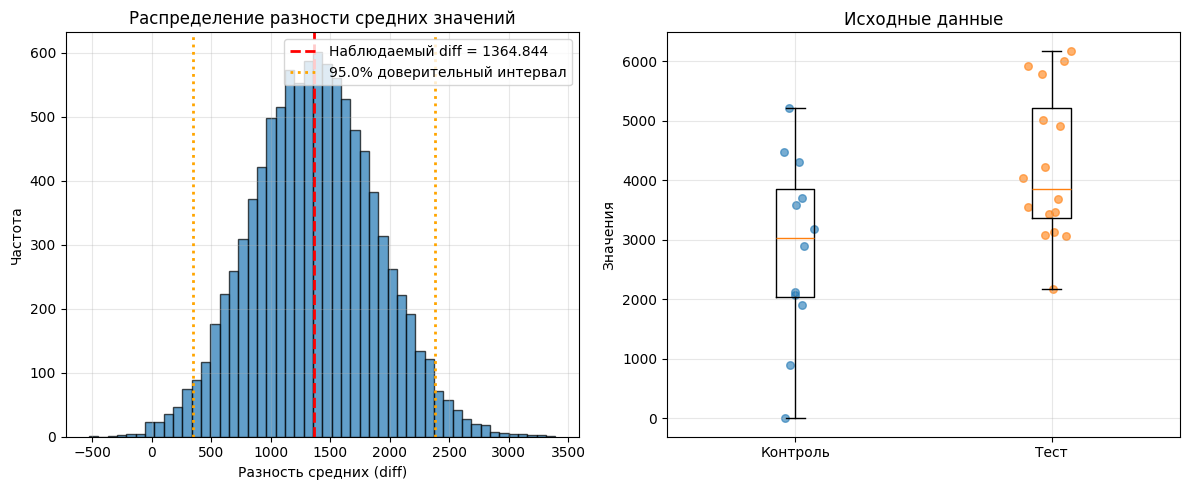

In [ ]:
#тест по точке 69
#выведем полный результат. В этом окне - график, и отдельно значения
values_0 = means_test_df02[(means_test_df02['id_trading_point'] == 69) & (means_test_df02['nflag_test'] == 0)]['amt_payment']
values_1 = means_test_df02[(means_test_df02['id_trading_point'] == 69) & (means_test_df02['nflag_test'] == 1)]['amt_payment']
means_test_demonstration = Bootstrap_means_test(values_0, values_1, alpha = 0.05)
means_test_res, means_test_distribution, means_test_plot = means_test_demonstration.get_boot(n_samples = 10000, is_full_results = True)
means_test_plot

In [ ]:
means_test_res

{'diff': np.float64(1364.8437500000005),
 'Доверительный интервал': (np.float64(347.5890079429761),
  np.float64(2382.098492057025)),
 'Значимость bt': True}

Бутстреп показал, что 0 - за пределами доверительного интервала.<br>
Значит, H0 для сегмента "Точка №69" отвергаем. Между средними имеются статистически значимые отличия

#4 Тест изменения конверсии

**Общая формулировка гипотезы:**<br>
«Если добавить новый тип уведомлений - пуш-уведомления, улучшится конверсия в покупку»<br>
<br>
**Основная гипотеза:**<br>
H0 - новый тип уведомлений, пуш-уведомления, не влияет на конверсию в заказ<br>
**Альтернативня гипотеза:**<br>
H1 - новый тип уведомлений, пуш-уведомления, влияет на конверсию в заказ<br>

##4.1 Проведение теста конверсии с сегментацией по городам

In [ ]:
conversion_test_by_city = {}
mde = 0.05
alpha = 0.05
for city in conversion_test_df02['city'].unique():
  #формирование выборок
  conv_test_col_0 = conversion_test_df02[(conversion_test_df02['city'] == city)]['nflag_test']
  conv_test_col_1 = conversion_test_df02[(conversion_test_df02['city'] == city)]['flag_payment']
  conv_test_result = Conversion_testing(conv_test_col_0, conv_test_col_1, mde = mde, alpha = alpha).get_test()
  conversion_test_by_city[city] = conv_test_result
pd.DataFrame(conversion_test_by_city).T

,Размер тест.,Размер контроль.,Статистика,Значение,H0,p-value,α,Изменение конверсии
Красноярск,3037,2900,Chi2,0.191897,Верна,0.661343,0.05,Не обнаружено
Мурманск,1055,1065,F-test,1.106477,Верна,0.254745,0.05,Не обнаружено
Казань,2500,2577,Chi2,0.065953,Верна,0.797323,0.05,Не обнаружено
Санкт-Петербург,4445,4434,Chi2,94.692347,Опровергается,0.0,0.05,10.35%
Москва,6121,6224,Chi2,34.288942,Опровергается,0.0,0.05,5.28%
Саратов,1013,1109,F-test,1.101981,Верна,0.288637,0.05,Не обнаружено
Тольятти,190,167,F-test,1.387787,Верна,0.155181,0.05,Не обнаружено
Тюмень,130,146,F-test,1.817916,Опровергается,0.015689,0.05,14.72%
Волгоград,657,703,F-test,0.848523,Верна,0.137511,0.05,Не обнаружено
Сочи,796,806,F-test,0.831452,Верна,0.070043,0.05,Не обнаружено


**Вывод:**<br>
Для большей части городов, в которых присутствует ритейлер, новый тип уведомлений не привел к значимым изменениям конверсии.<br>
В Москве, Санкт-Петербурге, Тюмени и Самара отмечен значительный прирост конверсии


##4.2 Проведение теста конверсии с сегментацией по торговым точкам

In [ ]:
conversion_test_by_tpoint = {}
mde = 0.05
alpha = 0.05
for tp_number in conversion_test_df02['id_trading_point'].unique():
  #формирование выборок
  conv_test_col_0 = conversion_test_df02[(conversion_test_df02['id_trading_point'] == tp_number)]['nflag_test']
  conv_test_col_1 = conversion_test_df02[(conversion_test_df02['id_trading_point'] == tp_number) ]['flag_payment']

  #получение данных о городе
  curr_city = conversion_test_df02[(conversion_test_df02['id_trading_point'] == tp_number)]['city'].iloc[0]
  #формирование выборок
  conv_test_result = Conversion_testing(conv_test_col_0, conv_test_col_1, mde = mde, alpha = alpha).get_test()
  conversion_test_by_tpoint[(curr_city, tp_number)] = conv_test_result
pd.DataFrame(conversion_test_by_tpoint).T

Размер тест. Размер контроль. Статистика   Значение  \
Красноярск      212           593              575     F-test   1.032076   
Мурманск        54            633              640     F-test   1.038591   
Казань          991           270              294     F-test   1.240122   
Санкт-Петербург 453          1066             1049     F-test   1.673758   
Москва          2652         2273             2370       Chi2  54.827056   
Красноярск      278           535              489     F-test   1.054828   
Москва          6543          660              689     F-test   1.056877   
Казань          699           482              494     F-test   0.844302   
                477           382              386     F-test   0.966414   
                544           377              416     F-test   1.189377   
Саратов         80            844              880     F-test   1.106825   
Тольятти        88            190              167     F-test   1.387787   
Тюмень          19            130              146     F-test   1.817916   
Санкт-Петербург 112           652              683     F-test   1.323242   
Волгоград       66            657              703     F-test   0.848523   
Санкт-Петербург 394           104               85     F-test   1.416499   
Сочи            72            609              639     F-test   0.876992   
Красноярск      202           551              565     F-test   0.939599   
Владимир        11            509              608     F-test   1.265746   
Мурманск        55            422              425     F-test   1.213733   
Москва          1287          369              357     F-test   2.158881   
Санкт-Петербург 801           225              212     F-test   1.588719   
Самара          33            232              258     F-test  24.231423   
Красноярск      444           650              562     F-test   0.914452   
Краснодар       1101          785              869     F-test   0.812179   
Самара          34            225              253     F-test   3.218187   
Санкт-Петербург 573           177              160     F-test   3.091398   
Краснодар       1989          239              270       Chi2   0.239316   
Санкт-Петербург 576           630              657     F-test   1.216894   
                309           240              238     F-test    1.24726   
Москва          3987          801              785     F-test   0.937024   
                8543          148              140     F-test   1.321215   
Казань          516           634              636     F-test   1.052745   
Санкт-Петербург 900           335              341     F-test   1.770699   
Москва          2212          421              397     F-test   0.794089   
Казань          439           355              351     F-test   0.925123   
Самара          35            214              194     F-test    2.69789   
Санкт-Петербург 117           625              587     F-test   1.556659   
Москва          1654          792              775     F-test   1.087383   
Красноярск      277           708              709     F-test   0.963941   
Сахалинск       69             75               78     F-test   1.491525   
Саратов         82            169              229     F-test   1.101734   
Санкт-Петербург 213           232              255     F-test   1.557169   
Самара          36            131              141     F-test   2.765685   
Сочи            73            187              167     F-test    0.68937   
Санкт-Петербург 891           159              167     F-test   1.720649   
Москва          9121          131              108     F-test   0.824502   
                9931          153              137     F-test   0.521191   
Дмитров         2              78               71     F-test   1.192547   
Москва          3786          236              278     F-test   1.058349   
                1002          137              188     F-test   2.592753   

                                 H0   p-value     α Изменение конвер

**Вывод:**<br>
Для большей части торговых точек, новый тип уведомлений не привел к значимым изменениям конверсии.<br>
В точках 9931 и 1101 отмечена просадка конверсии, а в 16 (шестнадцати) других точках со значимыми изменениями - рост

#5 Тест изменения средних платежей

**Общая формулировка гипотезы:**<br>
«Если добавить новый тип уведомлений - пуш-уведомления, повысится средний чек покупок»<br>
<br>
**Основная гипотеза:**<br>
H0 - новый тип уведомлений, пуш-уведомления, не влияет на средний чек<br>
**Альтернативня гипотеза:**<br>
H1 - новый тип уведомлений, пуш-уведомления, влияет на средний чек<br>

##5.1 Описанией полей данных

**Поля итоговой таблицы, включаемые в тест согласно ТЗ**

**city** — город.<br>
**id_trading_point** — уникальный идентификатор торговой точки, к которой прикреплен данный пользователь.<br>
**count_test** — кол-во наблюдений в тестовой группе.<br>
**count_control** — кол-во наблюдений в контрольной группе.<br>
**count_all** — суммарное кол-во наблюдений.<br>
**percent_count** — процент кол-ва наблюдений данной ТТ от всех наблюдений.<br>
**avg_payment_test** — средний платеж в тестовой группе.<br>
**avg_payment_control** — средний платеж в контрольной группе.<br>
**diff** — разница между средними платежами.<br>
**sigma_test** — стандартное отклонение платежей в тестовой группе.<br>
**sigma_control** — стандартное отклонение платежей в контрольной группе.<br>
**ttest** — значение статистического критерия (критерий Стьюдента для сравнения средних платежей).<br>
**pvalue_ttest** — pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей).<br>
**flag_result** —  флаг (лейбл), по которому можно будет разделить торговые точки по результатам эксперимента.<br>

Для целей теста создадим также дополнительные колонки, которые помогут оценить результат.<br>
При экспорте в excel они будут удалены:<br>
**Mann-Whitney** - значение критерия Манна-Уитни<br>
**pvalue_MWtest** - уровень значимости результата теста Манна-Уитни<br>
**Значимость MW** - логическое поле True/False<br>
**Значимость t**	- логическое поле True/False<br>
**Значимость bt**- логическое поле True/False<br>
**Значимость all**	- подсчет согласия тестов по значимости, вида 1/3, 2/3, 3/3<br>

##5.2 Проведение тестов с сегментацией по городам

In [ ]:
alpha = 0.05
test_by_city = {}
for city in means_test_df02['city'].unique():
  #формирование выборок
  sample_0 = means_test_df02[(means_test_df02['city'] == city) & (means_test_df02['nflag_test'] == 0)]['amt_payment']
  sample_1 = means_test_df02[(means_test_df02['city'] == city) & (means_test_df02['nflag_test'] == 1)]['amt_payment']

  #получение данных о городе
  print(city)

  #результаты тестов
  mw_results = mann_whitney_test(sample_0, sample_1, alpha = alpha)
  t_test_results = t_test(sample_0, sample_1, alpha = alpha)
  boot_strap_results = (Bootstrap_means_test(sample_0, sample_1, alpha = alpha)
                       .get_boot(n_samples = 10000, is_full_results = False))

  #данные о выборках
  len_0 = len(sample_0)
  len_1 = len(sample_1)
  mean_0 = np.mean(sample_0)
  mean_1 = np.mean(sample_1)
  diff = mean_1 - mean_0
  samples_info = ({'count_test': len_1,
                 'count_control': len_0,
                 'count_all': len_0 + len_1,
                 'avg_payment_test': round((mean_1),4),
                 'avg_payment_control': round((mean_0),4),
                 'diff': diff,
                 'sigma_test': sample_1.std(),
                 'sigma_control': sample_0.std()})
  #объединение данных о выборках и результаты тестов в единый словарь
  combine_results = {}

  for another_res in [samples_info, mw_results, t_test_results, boot_strap_results]:
    combine_results.update(another_res)

  #Добавим еще один столбец, который покажет, сколько тестов показали значимость результата из всех:
  combine_results['Значимость all'] = f'{combine_results['Значимость MW'] + combine_results['Значимость t'] + combine_results['Значимость bt']} / 3'

  #Добавление объединенного словаря с результатами тестов и информацией по текущей точке в общий словарь результатов
  #Ключ словаря - кортеж вида (Город, Номер точки)
  test_by_city[city] = combine_results

#формируем DataFrame из словаря со всеми результатами тестов:
city_mean_tests_df = pd.DataFrame(test_by_city).T.sort_index(level = 0, ascending= False)

#дополним фрейм информацией о том, какую долю каждая город занимает в общем числе продаж
#векторное деление столбца count_all на сумму этого же столбца
percent_count = city_mean_tests_df['count_all'] / (city_mean_tests_df['count_all'].sum())

city_mean_tests_df.insert(loc = 3, column = 'percent_count', value = percent_count)

#дополним фрейм данных столбцом, позволяющим распределить точки по результату - положительный, отрицательный, нейтральный
#создадим столбец - flag_result. Значения is_positive, is_negative, is_neutral для положительного, отрицательного, нейтрального соответственно
city_mean_tests_df['flag_result'] = city_mean_tests_df.apply(lambda row: 'is_positive' if row['Значимость all'] in ['2 / 3', '3 / 3'] and row['diff'] > 0
                                                                else 'is_negative' if row['Значимость all'] in ['2 / 3', '3 / 3'] and row['diff'] < 0
                                                                else 'is_neutral', axis = 1)


with pd.option_context("display.max_rows", 100), pd.option_context('display.max_columns', 60):
  display(city_mean_tests_df)

Санкт-Петербург


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва


  0%|          | 0/10000 [00:00<?, ?it/s]

Саратов


  0%|          | 0/10000 [00:00<?, ?it/s]

Тольятти


  0%|          | 0/10000 [00:00<?, ?it/s]

Владимир


  0%|          | 0/10000 [00:00<?, ?it/s]

Мурманск


  0%|          | 0/10000 [00:00<?, ?it/s]

Красноярск


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань


  0%|          | 0/10000 [00:00<?, ?it/s]

Самара


  0%|          | 0/10000 [00:00<?, ?it/s]

Волгоград


  0%|          | 0/10000 [00:00<?, ?it/s]

Сочи


  0%|          | 0/10000 [00:00<?, ?it/s]

Краснодар


  0%|          | 0/10000 [00:00<?, ?it/s]

Дмитров


  0%|          | 0/10000 [00:00<?, ?it/s]

Тюмень


  0%|          | 0/10000 [00:00<?, ?it/s]

Сахалинск


  0%|          | 0/10000 [00:00<?, ?it/s]

,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result
Тюмень,69,56,125,0.005213,3256.4058,3307.5536,-51.147774,1411.772182,1401.323013,1907.5,0.905155,False,0.202098,0.840174,False,False,0 / 3,is_neutral
Тольятти,125,97,222,0.009259,3358.0547,3463.811,-105.75633,1471.835114,1357.831808,6355.5,0.53776,False,0.549163,0.583451,False,False,0 / 3,is_neutral
Сочи,428,470,898,0.037453,3384.3993,3507.9777,-123.578322,1416.384827,1394.896204,104875.0,0.268617,False,1.316266,0.188421,False,False,0 / 3,is_neutral
Сахалинск,16,12,28,0.001168,4228.0521,2863.2083,1364.84375,1247.568951,1530.152153,52.0,0.043442,True,-2.600723,0.015144,True,True,3 / 3,is_positive
Саратов,612,644,1256,0.052384,3353.1597,3470.1073,-116.94755,1446.887019,1336.978647,207005.5,0.121824,False,1.485671,0.137622,False,False,0 / 3,is_neutral
Санкт-Петербург,2474,2009,4483,0.186971,3377.4512,3468.8178,-91.366684,1413.115606,1432.874772,2570239.5,0.048288,True,2.139403,0.032457,True,True,3 / 3,is_negative
Самара,586,380,966,0.040289,3389.2929,3359.566,29.726938,1390.209225,1461.949326,110644.5,0.869678,False,-0.314706,0.753069,False,False,0 / 3,is_neutral
Мурманск,471,449,920,0.03837,3387.4176,3438.7117,-51.294104,1457.684915,1319.972078,105676.5,0.987623,False,0.559938,0.575659,False,False,0 / 3,is_neutral
Москва,3368,3096,6464,0.269592,3707.0403,3436.8817,270.158599,1438.621872,1410.065066,4621004.5,0.0,True,-7.620814,0.0,True,True,3 / 3,is_positive
Красноярск,1714,1654,3368,0.140468,3469.6947,3424.9994,44.695313,1414.302951,1386.489356,1396869.5,0.465102,False,-0.925763,0.354635,False,False,0 / 3,is_neutral


Города, где вцелом отмечен значимый рост среднего чека

In [ ]:
city_mean_tests_df[city_mean_tests_df['flag_result'] == 'is_positive']

,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result
Сахалинск,16,12,28,0.001168,4228.0521,2863.2083,1364.84375,1247.568951,1530.152153,52.0,0.043442,True,-2.600723,0.015144,True,True,3 / 3,is_positive
Москва,3368,3096,6464,0.269592,3707.0403,3436.8817,270.158599,1438.621872,1410.065066,4621004.5,0.0,True,-7.620814,0.0,True,True,3 / 3,is_positive


Города, где вцелом отмечено значимое падение среднего чека

In [ ]:
city_mean_tests_df[city_mean_tests_df['flag_result'] == 'is_negative']

,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result
Санкт-Петербург,2474,2009,4483,0.186971,3377.4512,3468.8178,-91.366684,1413.115606,1432.874772,2570239.5,0.048288,True,2.139403,0.032457,True,True,3 / 3,is_negative


**Вывод:** <br>
Из 15 городов, значимые изменения наблюдаются в 2х<br>
Москва и Сахалинск показали рост чека. Санкт-Петербург - падение<br>

##5.3 Проведение тестов с сегментацией по торговым точкам

In [ ]:
alpha = 0.05
test_by_tpoint = {}
for tp_number in means_test_df02['id_trading_point'].unique():
  #формирование выборок
  sample_0 = means_test_df02[(means_test_df02['id_trading_point'] == tp_number) & (means_test_df02['nflag_test'] == 0)]['amt_payment']
  sample_1 = means_test_df02[(means_test_df02['id_trading_point'] == tp_number) & (means_test_df02['nflag_test'] == 1)]['amt_payment']

  #получение данных о городе
  curr_city = means_test_df02[(means_test_df02['id_trading_point'] == tp_number)]['city'].iloc[0]
  print(curr_city, f'торговая точка №{tp_number}')

  #результаты тестов
  mw_results = mann_whitney_test(sample_0, sample_1, alpha = alpha)
  t_test_results = t_test(sample_0, sample_1, alpha = alpha)
  boot_strap_results = (Bootstrap_means_test(sample_0, sample_1, alpha = alpha)
                       .get_boot(n_samples = 10000, is_full_results = False))

  #данные о выборках
  len_0 = len(sample_0)
  len_1 = len(sample_1)
  mean_0 = np.mean(sample_0)
  mean_1 = np.mean(sample_1)
  diff = mean_1 - mean_0
  samples_info = ({'count_test': len_1,
                 'count_control': len_0,
                 'count_all': len_0 + len_1,
                 'avg_payment_test': round((mean_1),4),
                 'avg_payment_control': round((mean_0),4),
                 'diff': diff,
                 'sigma_test': sample_1.std(),
                 'sigma_control': sample_0.std()})
  #объединение данных о выборках и результаты тестов в единый словарь
  combine_results = {}

  for another_res in [samples_info, mw_results, t_test_results, boot_strap_results]:
    combine_results.update(another_res)

  #Добавим еще один столбец, который покажет, сколько тестов показали значимость результата из всех:
  combine_results['Значимость all'] = f'{combine_results['Значимость MW'] + combine_results['Значимость t'] + combine_results['Значимость bt']} / 3'

  #Добавление объединенного словаря с результатами тестов и информацией по текущей точке в общий словарь результатов
  #Ключ словаря - кортеж вида (Город, Номер точки)
  test_by_tpoint[(curr_city, tp_number)] = combine_results

#формируем DataFrame из словаря со всеми результатами тестов:
tp_mean_tests_df = pd.DataFrame(test_by_tpoint).T.sort_index(level = 0, ascending= False)

#дополним фрейм информацией о том, какую долю каждая точка занимает в общем числе продаж
#векторное деление столбца count_all на сумму этого же столбца
percent_count = tp_mean_tests_df['count_all'] / (tp_mean_tests_df['count_all'].sum())

tp_mean_tests_df.insert(loc = 3, column = 'percent_count', value = percent_count)

#дополним фрейм данных столбцом, позволяющим распределить точки по результату - положительный, отрицательный, нейтральный
#создадим столбец - flag_result. Значения is_positive, is_negative, is_neutral для положительного, отрицательного, нейтрального соответственно
tp_mean_tests_df['flag_result'] = tp_mean_tests_df.apply(lambda row: 'is_positive' if row['Значимость all'] in ['2 / 3', '3 / 3'] and row['diff'] > 0
                                                                else 'is_negative' if row['Значимость all'] in ['2 / 3', '3 / 3'] and row['diff'] < 0
                                                                else 'is_neutral', axis = 1)


with pd.option_context("display.max_rows", 100), pd.option_context('display.max_columns', 60):
  display(tp_mean_tests_df)

Санкт-Петербург торговая точка №453


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №2652


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №112


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №3786


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №117


  0%|          | 0/10000 [00:00<?, ?it/s]

Саратов торговая точка №80


  0%|          | 0/10000 [00:00<?, ?it/s]

Тольятти торговая точка №88


  0%|          | 0/10000 [00:00<?, ?it/s]

Владимир торговая точка №11


  0%|          | 0/10000 [00:00<?, ?it/s]

Мурманск торговая точка №55


  0%|          | 0/10000 [00:00<?, ?it/s]

Красноярск торговая точка №212


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань торговая точка №477


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №309


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань торговая точка №439


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №576


  0%|          | 0/10000 [00:00<?, ?it/s]

Самара торговая точка №33


  0%|          | 0/10000 [00:00<?, ?it/s]

Волгоград торговая точка №66


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №1287


  0%|          | 0/10000 [00:00<?, ?it/s]

Красноярск торговая точка №277


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №1654


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №3987


  0%|          | 0/10000 [00:00<?, ?it/s]

Красноярск торговая точка №202


  0%|          | 0/10000 [00:00<?, ?it/s]

Мурманск торговая точка №54


  0%|          | 0/10000 [00:00<?, ?it/s]

Сочи торговая точка №72


  0%|          | 0/10000 [00:00<?, ?it/s]

Красноярск торговая точка №444


  0%|          | 0/10000 [00:00<?, ?it/s]

Краснодар торговая точка №1101


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань торговая точка №544


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань торговая точка №699


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №900


  0%|          | 0/10000 [00:00<?, ?it/s]

Краснодар торговая точка №1989


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань торговая точка №991


  0%|          | 0/10000 [00:00<?, ?it/s]

Самара торговая точка №34


  0%|          | 0/10000 [00:00<?, ?it/s]

Дмитров торговая точка №2


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №213


  0%|          | 0/10000 [00:00<?, ?it/s]

Самара торговая точка №35


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №2212


  0%|          | 0/10000 [00:00<?, ?it/s]

Тюмень торговая точка №19


  0%|          | 0/10000 [00:00<?, ?it/s]

Казань торговая точка №516


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №8543


  0%|          | 0/10000 [00:00<?, ?it/s]

Красноярск торговая точка №278


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №801


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №6543


  0%|          | 0/10000 [00:00<?, ?it/s]

Саратов торговая точка №82


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №573


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №891


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №9121


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №1002


  0%|          | 0/10000 [00:00<?, ?it/s]

Москва торговая точка №9931


  0%|          | 0/10000 [00:00<?, ?it/s]

Самара торговая точка №36


  0%|          | 0/10000 [00:00<?, ?it/s]

Санкт-Петербург торговая точка №394


  0%|          | 0/10000 [00:00<?, ?it/s]

Сахалинск торговая точка №69


  0%|          | 0/10000 [00:00<?, ?it/s]

Сочи торговая точка №73


  0%|          | 0/10000 [00:00<?, ?it/s]

count_test count_control count_all percent_count  \
Тюмень          19           69            56       125      0.005213   
Тольятти        88          125            97       222      0.009259   
Сочи            73           96           101       197      0.008216   
                72          332           369       701      0.029236   
Сахалинск       69           16            12        28      0.001168   
Саратов         82          105           137       242      0.010093   
                80          507           507      1014      0.042291   
Санкт-Петербург 900         187           142       329      0.013721   
                891         101            84       185      0.007716   
                801         146           114       260      0.010844   
                576         222           203       425      0.017725   
                573         115            60       175      0.007299   
                453         607           463      1070      0.044626   
                394          33            21        54      0.002252   
                309         146           132       278      0.011594   
                213         156           145       301      0.012554   
                117         378           291       669      0.027902   
                112         383           354       737      0.030738   
Самара          36           60            33        93      0.003879   
                35          139            79       218      0.009092   
                34          161           111       272      0.011344   
                33          226           157       383      0.015974   
Мурманск        55          220           201       421      0.017558   
                54          251           248       499      0.020812   
Москва          9931         56            72       128      0.005338   
                9121         58            53       111      0.004629   
                8543         66            53       119      0.004963   
                6543        279           282       561      0.023397   
                3987        311           317       628      0.026192   
                3786        155           179       334       0.01393   
                2652       1370          1171      2541      0.105977   
                2212        277           281       558      0.023272   
                1654        498           472       970      0.040455   
                1287        204           130       334       0.01393   
                1002         94            86       180      0.007507   
Красноярск      444         371           333       704      0.029361   
                278         297           265       562      0.023439   
                277         381           388       769      0.032072   
                212         312           298       610      0.025441   
                202         353           370       723      0.030154   
Краснодар       1989        236           264       500      0.020853   
                1101        403           491       894      0.037286   
Казань          991         144           141       285      0.011886   
                699         211           237       448      0.018685   
                544         183           184       367      0.015306   
                516         350           343       693      0.028903   
                477         167           172       339      0.014139   
                439         156           161       317      0.013221   
Дмитров         2             9             7        16      0.000667   
Волгоград       66          371           425       796      0.033198   
Владимир        11          286           306       592       0.02469   

                     avg_payment_test avg_payment_control         diff  \
Тюмень          19          3256.4058           3307.5536   -51.147774   
Тольятти        88          3358.0547            3463.811   -105.75633   
Со

Все значимые результаты:

In [ ]:
tp_mean_tests_df[tp_mean_tests_df['flag_result'] != 'is_neutral']

count_test count_control count_all percent_count  \
Сахалинск  69           16            12        28      0.001168   
Мурманск   55          220           201       421      0.017558   
Москва     9121         58            53       111      0.004629   
           1654        498           472       970      0.040455   
           1002         94            86       180      0.007507   
Красноярск 202         353           370       723      0.030154   
Казань     544         183           184       367      0.015306   

                avg_payment_test avg_payment_control         diff  \
Сахалинск  69          4228.0521           2863.2083   1364.84375   
Мурманск   55          3234.4076           3511.1133  -276.705774   
Москва     9121        3947.5316           3234.1604   713.371232   
           1654        4312.4259           3425.6969   886.728976   
           1002        5028.9124           3679.3857  1349.526752   
Красноярск 202         3624.7421           3406.3762   218.365899   
Казань     544         3734.3011           3443.9041   290.397017   

                  sigma_test sigma_control Mann-Whitney pvalue_MWtest  \
Сахалинск  69    1247.568951   1530.152153         52.0      0.043442   
Мурманск   55    1435.145013   1326.220627      24298.5      0.079331   
Москва     9121  1499.258338   1273.155461       1073.0      0.006211   
           1654  1073.519931   1401.408827      70020.5           0.0   
           1002  1381.114626   1496.727031       2066.0           0.0   
Красноярск 202   1444.512193   1347.117561      59585.0      0.041603   
Казань     544   1320.480498   1331.848093      14492.5      0.021127   

                Значимость MW     t-test pvalue_ttest Значимость t  \
Сахалинск  69            True  -2.600723     0.015144         True   
Мурманск   55           False   2.056025     0.040399         True   
Москва     9121          True  -2.709126     0.007842         True   
           1654          True -11.019688          0.0         True   
           1002          True  -6.291521          0.0         True   
Красноярск 202           True  -2.103144     0.035799         True   
Казань     544           True  -2.097428     0.036643         True   

                Значимость bt Значимость all  flag_result  
Сахалинск  69            True          3 / 3  is_positive  
Мурманск   55            True          2 / 3  is_negative  
Москва     9121          True          3 / 3  is_positive  
           1654          True          3 / 3  is_positive  
           1002          True          3 / 3  is_positive  
Красноярск 202           True          3 / 3  is_positive  
Казань     544           True          3 / 3  is_positive

Все значимые положительные исходы:

In [ ]:
tp_mean_tests_df[tp_mean_tests_df['flag_result'] == 'is_positive']

count_test count_control count_all percent_count  \
Сахалинск  69           16            12        28      0.001168   
Москва     9121         58            53       111      0.004629   
           1654        498           472       970      0.040455   
           1002         94            86       180      0.007507   
Красноярск 202         353           370       723      0.030154   
Казань     544         183           184       367      0.015306   

                avg_payment_test avg_payment_control         diff  \
Сахалинск  69          4228.0521           2863.2083   1364.84375   
Москва     9121        3947.5316           3234.1604   713.371232   
           1654        4312.4259           3425.6969   886.728976   
           1002        5028.9124           3679.3857  1349.526752   
Красноярск 202         3624.7421           3406.3762   218.365899   
Казань     544         3734.3011           3443.9041   290.397017   

                  sigma_test sigma_control Mann-Whitney pvalue_MWtest  \
Сахалинск  69    1247.568951   1530.152153         52.0      0.043442   
Москва     9121  1499.258338   1273.155461       1073.0      0.006211   
           1654  1073.519931   1401.408827      70020.5           0.0   
           1002  1381.114626   1496.727031       2066.0           0.0   
Красноярск 202   1444.512193   1347.117561      59585.0      0.041603   
Казань     544   1320.480498   1331.848093      14492.5      0.021127   

                Значимость MW     t-test pvalue_ttest Значимость t  \
Сахалинск  69            True  -2.600723     0.015144         True   
Москва     9121          True  -2.709126     0.007842         True   
           1654          True -11.019688          0.0         True   
           1002          True  -6.291521          0.0         True   
Красноярск 202           True  -2.103144     0.035799         True   
Казань     544           True  -2.097428     0.036643         True   

                Значимость bt Значимость all  flag_result  
Сахалинск  69            True          3 / 3  is_positive  
Москва     9121          True          3 / 3  is_positive  
           1654          True          3 / 3  is_positive  
           1002          True          3 / 3  is_positive  
Красноярск 202           True          3 / 3  is_positive  
Казань     544           True          3 / 3  is_positive

Все значимые отрицательные исходы:

In [ ]:
tp_mean_tests_df[tp_mean_tests_df['flag_result'] == 'is_negative']

,,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result
Мурманск,55,220,201,421,0.017558,3234.4076,3511.1133,-276.705774,1435.145013,1326.220627,24298.5,0.079331,False,2.056025,0.040399,True,True,2 / 3,is_negative


In [ ]:
print(f'''Всего точек {tp_mean_tests_df.shape[0]}
Значимый результат обнаружен для {tp_mean_tests_df[tp_mean_tests_df['flag_result'] != 'is_neutral'].shape[0]} точек
Процент точек со значимым результатом {round((tp_mean_tests_df[tp_mean_tests_df['flag_result'] != 'is_neutral'].shape[0]/tp_mean_tests_df.shape[0])*100, 2)}%''')

Всего точек 51
Значимый результат обнаружен для 7 точек
Процент точек со значимым результатом 13.73%


**Вывод:** <br>
Из 51 торговой точки, значимые изменения наблюдаются в 7, или 13,71%<br>
Москва и Сахалинск показали рост чека. Санкт-Петербург - падение<br>
6 точек показали рост среднего чека и 1 - падение

Проверим согласие между тестами

In [ ]:
tp_mean_tests_df[(tp_mean_tests_df['Значимость t'] != tp_mean_tests_df['Значимость bt'])]

,,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result


In [ ]:
tp_mean_tests_df[(tp_mean_tests_df['Значимость MW'] != tp_mean_tests_df['Значимость bt'])]

,,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result
Мурманск,55,220,201,421,0.017558,3234.4076,3511.1133,-276.705774,1435.145013,1326.220627,24298.5,0.079331,False,2.056025,0.040399,True,True,2 / 3,is_negative


In [ ]:
tp_mean_tests_df[(tp_mean_tests_df['Значимость t'] != tp_mean_tests_df['Значимость MW'])]

,,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,Mann-Whitney,pvalue_MWtest,Значимость MW,t-test,pvalue_ttest,Значимость t,Значимость bt,Значимость all,flag_result
Мурманск,55,220,201,421,0.017558,3234.4076,3511.1133,-276.705774,1435.145013,1326.220627,24298.5,0.079331,False,2.056025,0.040399,True,True,2 / 3,is_negative


#6 Экспорт в excel

Удалим колонки, не требующиеся по ТЗ:

In [ ]:
tp_mean_tests_export_df = tp_mean_tests_df.drop(columns = ['Mann-Whitney',
                                                           'pvalue_MWtest',
                                                           'Значимость MW',
                                                           'Значимость t',
                                                           'Значимость bt',
                                                           'Значимость all'])
tp_mean_tests_export_df = tp_mean_tests_export_df.reset_index(drop = False)
tp_mean_tests_export_df = (tp_mean_tests_export_df.rename(columns = {'level_0': 'city', 'level_1': 'id_trading_point'})
                                                  .sort_values(by = ['city', 'id_trading_point'])
                                                  .reset_index(drop = True))
tp_mean_tests_export_df.head(10)

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,t-test,pvalue_ttest,flag_result
0,Владимир,11,286,306,592,0.02469,3534.3048,3464.3488,69.955977,1480.933759,1492.599687,-0.57201,0.567533,is_neutral
1,Волгоград,66,371,425,796,0.033198,3249.226,3404.292,-155.065995,1446.420983,1459.372151,1.501657,0.133583,is_neutral
2,Дмитров,2,9,7,16,0.000667,2879.1481,3693.7857,-814.637566,1103.914035,697.439117,1.699388,0.111347,is_neutral
3,Казань,439,156,161,317,0.013221,3650.5306,3540.6559,109.874661,1103.967896,1415.951374,-0.771827,0.440822,is_neutral
4,Казань,477,167,172,339,0.014139,3555.7415,3554.1918,1.549753,1286.115466,1428.027108,-0.010489,0.991637,is_neutral
5,Казань,516,350,343,693,0.028903,3651.7879,3635.7198,16.06808,1205.842821,1400.476842,-0.161714,0.87158,is_neutral
6,Казань,544,183,184,367,0.015306,3734.3011,3443.9041,290.397017,1320.480498,1331.848093,-2.097428,0.036643,is_positive
7,Казань,699,211,237,448,0.018685,3552.652,3472.721,79.931025,1239.447078,1289.538931,-0.666944,0.505153,is_neutral
8,Казань,991,144,141,285,0.011886,3746.0848,3563.8958,182.189014,1325.708804,1459.494139,-1.102413,0.271232,is_neutral
9,Краснодар,1101,403,491,894,0.037286,3433.2572,3458.036,-24.778744,1407.541504,1363.632988,0.266437,0.789964,is_neutral


Произведем экспорт в excel для формирования калькулятора, согласно ТЗ:

In [ ]:
#помещаем нейтральные результаты на лист is_neutral с нейтральными исходами
tp_mean_tests_export_df[tp_mean_tests_export_df['flag_result'] == 'is_neutral'].to_excel('/content/drive/MyDrive/Диплом. SkyPro/Калькулятор.xlsx', sheet_name='is_neutral')

with pd.ExcelWriter('/content/drive/MyDrive/Диплом. SkyPro/Калькулятор.xlsx',
                    mode='a') as writer:
    #добавляем в файл листы. Положительные и отрицательные исходы на лист is_positive и is_negative соответственно
    tp_mean_tests_export_df[tp_mean_tests_export_df['flag_result'] == 'is_positive'].to_excel(writer, sheet_name='is_positive')
    tp_mean_tests_export_df[tp_mean_tests_export_df['flag_result'] == 'is_negative'].to_excel(writer, sheet_name='is_negative')

#7 Информационные ссылки и литература

1) С.Бослаф. "Статистика для всех"<br>
https://www.litres.ru/book/sara-boslaf/statistika-dlya-vseh-22968987/?ysclid=mgxyoerh2167400240
2) University of Washington courses.<br>
https://courses.washington.edu/matlab1/Bootstrap_examples.html
3) "Бутстреп и А/Б тестирование". habr.com<br>
https://habr.com/ru/companies/X5Tech/articles/679842/?ysclid=mgxy5fjcnx656774257
4) SciPy.org. Документация<br>
https://docs.scipy.org/doc/